In [7]:
import glob
import pandas as pd
import sys
import numpy as np
import pickle
import imp
from scipy.stats import pearsonr,spearmanr,ttest_1samp,ttest_rel,ttest_ind, binom_test,median_test,beta
import statsmodels.api as sm
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import Rectangle
%matplotlib inline

In [8]:
sys.path.append('../code_for_data_processing/')
sys.path.append('../code_for_model_fitting/')
sys.path.append('../code_mscl/')

import participants
imp.reload(participants)
from participants import get_all_participants_df

import loading_models
imp.reload(loading_models)
from loading_models import get_model_fit_data

import renaming
imp.reload(renaming)
from renaming import (name_replace_clinical, name_replace_stat, name_replace_modelsA,
                      name_replace_modelsB)

import model_utils
imp.reload(model_utils)
from model_utils import generate_data_from_model

from permutation import pearson_permutation_test

In [9]:
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'font.family': 'normal'})
labelsize =10
ticklabelsize=8
legendsize=8

### Get Data

In [10]:
MIDs_w_session3_data, df =get_all_participants_df(exclude=True)

In [12]:
modelnamelist =[
'model_bayes_wreport_asym_no_reported',  # 1
'model_bayes_wreport_basic_no_reported', # 2 
'model_RW_update_w_report_samelr_relfbscaling', # 3
'model_RW_update_w_report_samelr_nofbscaling', # 4
'model_RW_update_w_report_difflr_nofbscaling', # 5
'model_RW_update_w_report_samelr_fbscaling', # 6
'model_bayes_wreport_w_no_reported_decay_50', # 7
'model_bayes_wreport_w_no_reported_decay_prior', # 8
'model_bayes_wreport_basic', # 9
'model_bayes_wreport_no_decay', # 10
'model_bayes_wreport_decay_50', # 10 
'model_bayes_wreport_decay_prior',# 11
'model_bayes_wreport_two_rates_no_decay', # 12 fitting 
]

### Figure S1 - Factor / Subscale Correlations

In [13]:
factors = ['item_clinical.fa.omega3.g',
        'item_clinical.fa.omega3.anh',
        'item_clinical.fa.omega3.cog_anx']
traits = ['stai_state_sess3','stai_trait_anx_sess2',
        'stai_trait_anx_sess3','stai_trait_dep_sess2','stai_trait_dep_sess3',
        'cesd_dep_sess2', 'cesd_dep_sess3',
        'cesd_anh_sess2','cesd_anh_sess3',
        'cesd_som_sess2','cesd_som_sess3',
        'masq_aa','masq_ad','masq_as','masq_ds','pswq']
                  
dftmp = df[factors+traits]
dftmp.corr()

C = pd.DataFrame(np.round(dftmp.corr()[factors],2))

C_w_p = C.copy()
C_w_p = C_w_p.astype('str')
for trait in C.index:
    for metric in C.columns:
        x = dftmp[trait].values
        y = dftmp[metric].values
        r,p = pearsonr(x,y)
        C_w_p.loc[trait,metric]=''+str(round(r,2))#+'\n('+str(round(p,2))+')'
C_w_p.head()

,item_clinical.fa.omega3.g,item_clinical.fa.omega3.anh,item_clinical.fa.omega3.cog_anx
item_clinical.fa.omega3.g,1.0,-0.0,0.0
item_clinical.fa.omega3.anh,-0.0,1.0,0.0
item_clinical.fa.omega3.cog_anx,0.0,0.0,1.0
stai_state_sess3,0.36,0.3,0.09
stai_trait_anx_sess2,0.71,0.26,0.43


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


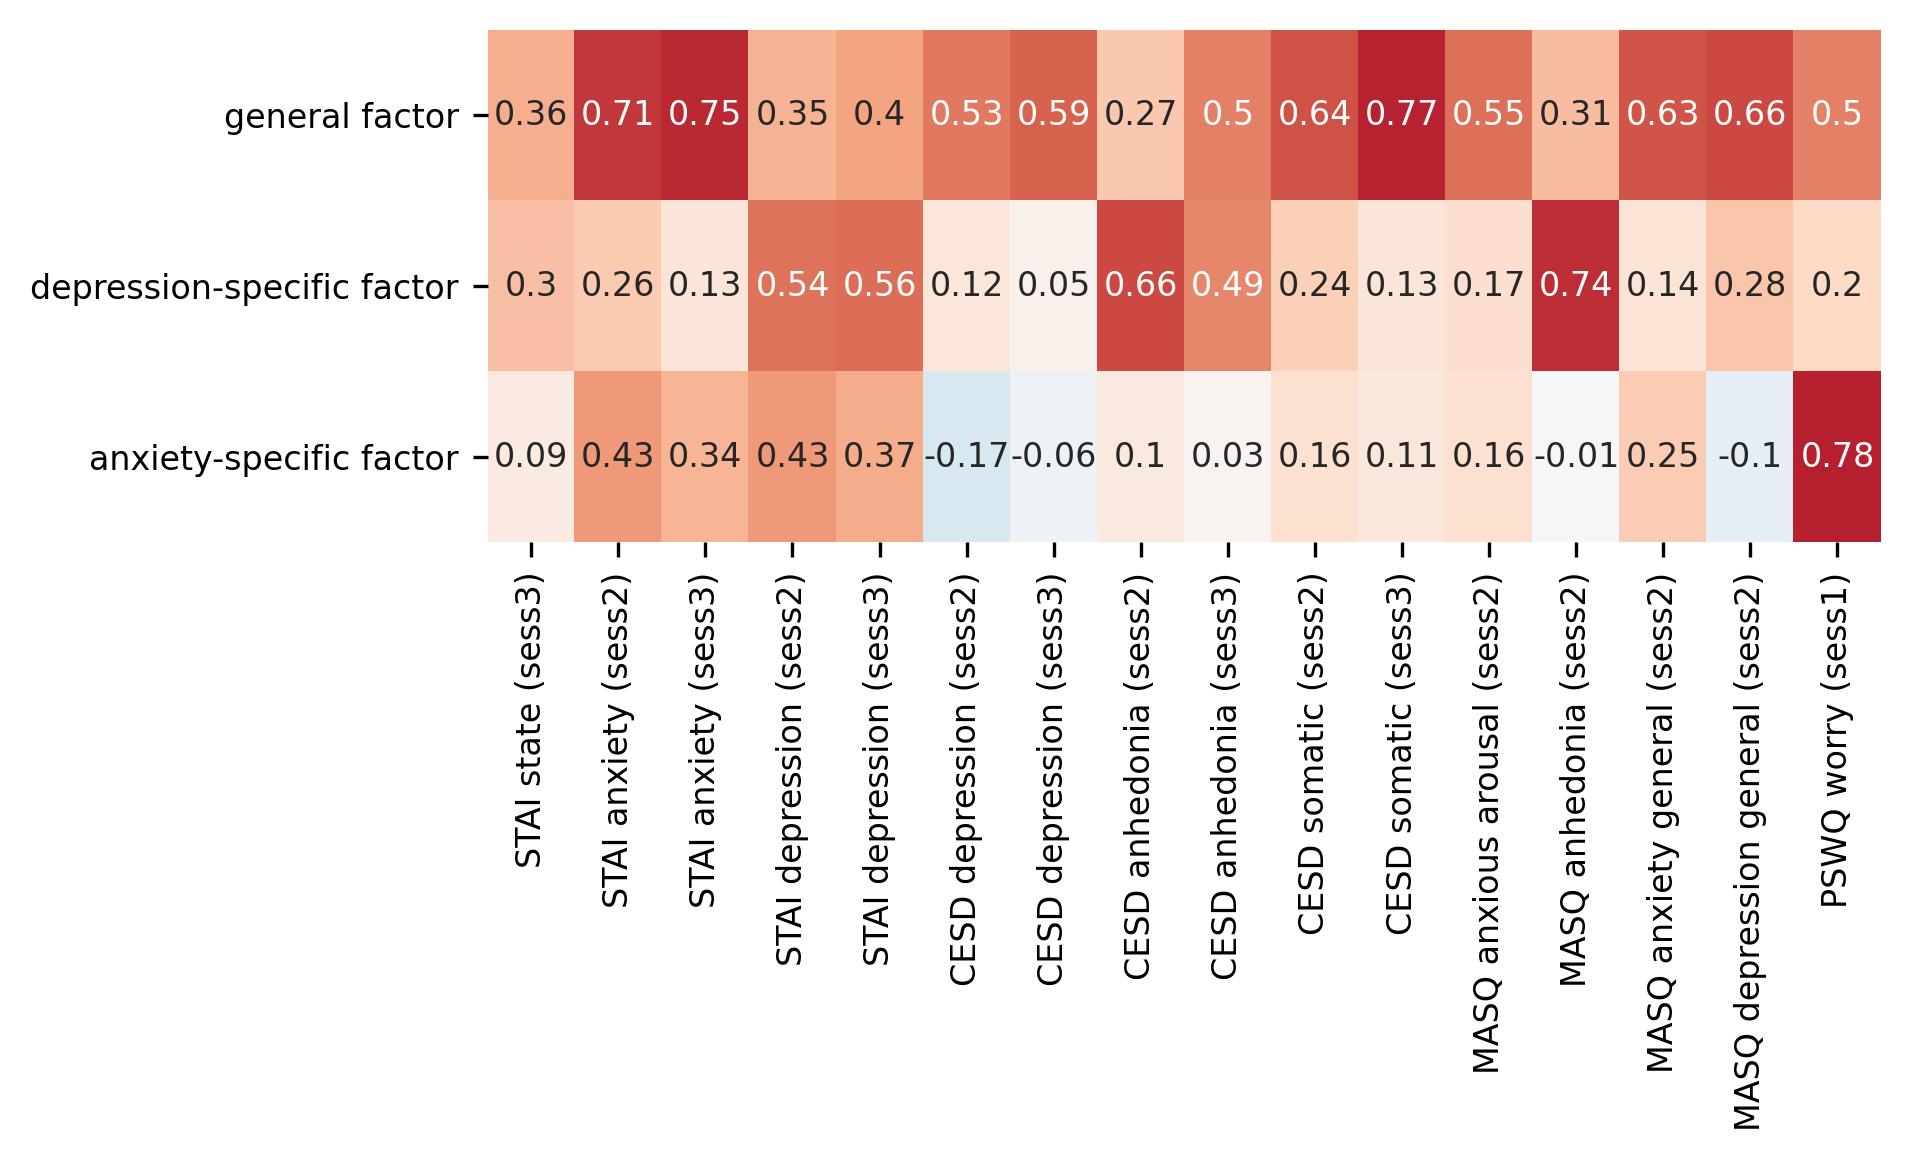

In [15]:
fig = plt.figure(figsize=(6.5,4),dpi=300, facecolor='w')

# rename 
C = C.rename(name_replace_clinical,axis=0)#.rename(rename_dict,axis=1)
C_w_p = C_w_p.rename(name_replace_clinical,axis=0)
traits_renamed = [name_replace_clinical[trait] if trait in name_replace_clinical else trait for trait in traits]
factors_renamed =[name_replace_clinical[factor] if factor in name_replace_clinical else factor for factor in factors]

ax = sns.heatmap(C.T[traits_renamed],annot=C_w_p.T[traits_renamed],vmax=1.0,vmin=-1,
                 cmap='RdBu_r', center=0,fmt='s',cbar=False,annot_kws = {'fontsize':8},cbar_kws ={'label':'Pearson r'})

plt.yticks(np.arange(3)+0.5,factors_renamed,rotation=0,fontsize=ticklabelsize);

plt.xticks(fontsize=ticklabelsize)

# change colorbar size 
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(8)
cbar_axes.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
#plt.savefig('../figs_paper_submission/S1.png')
#plt.savefig('../figs_paper_submission/S1.tif')

### Figure S2 - Qualitative Fits

In [16]:
modelname ='model_RW_update_w_report_samelr_relfbscaling'
model_fits_df,params = get_model_fit_data(modelname, df)

modelname2 ='model_bayes_wreport_asym_no_reported'
model_fits_df2,params2 = get_model_fit_data(modelname2, df)

modelname3 ='model_bayes_wreport_basic_no_reported'
model_fits_df3,params3 = get_model_fit_data(modelname3, df)

modelname4 ='model_RW_update_w_report_samelr_nofbscaling'
model_fits_df4,params4 = get_model_fit_data(modelname4, df)

../code_for_model_fitting/loading_models.py:33: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  fit = pickle.load( open(modelfits_folder+suffix1+\


In [17]:
(new_reported_beliefs,new_updates,new_pos_updates,new_neg_updates,
           feedbacks,estimates,updates,pos_updates,neg_updates)=generate_data_from_model(model_fits_df, df, S=1)

In [18]:
(new_reported_beliefs2,new_updates2,new_pos_updates2,new_neg_updates2,
           feedbacks2,estimates2,updates2,pos_updates2,neg_updates2)=generate_data_from_model(model_fits_df2, df, S=1) 

In [19]:
(new_reported_beliefs3,new_updates3,new_pos_updates3,new_neg_updates3,
           feedbacks3,estimates3,updates3,pos_updates3,neg_updates3)=generate_data_from_model(model_fits_df3, df, S=1)

In [20]:
(new_reported_beliefs4,new_updates4,new_pos_updates4,new_neg_updates4,
           feedbacks4,estimates4,updates4,pos_updates4,neg_updates4)=generate_data_from_model(model_fits_df4, df, S=1)

<ipython-input-21-226ddd70bfc9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,i+1)


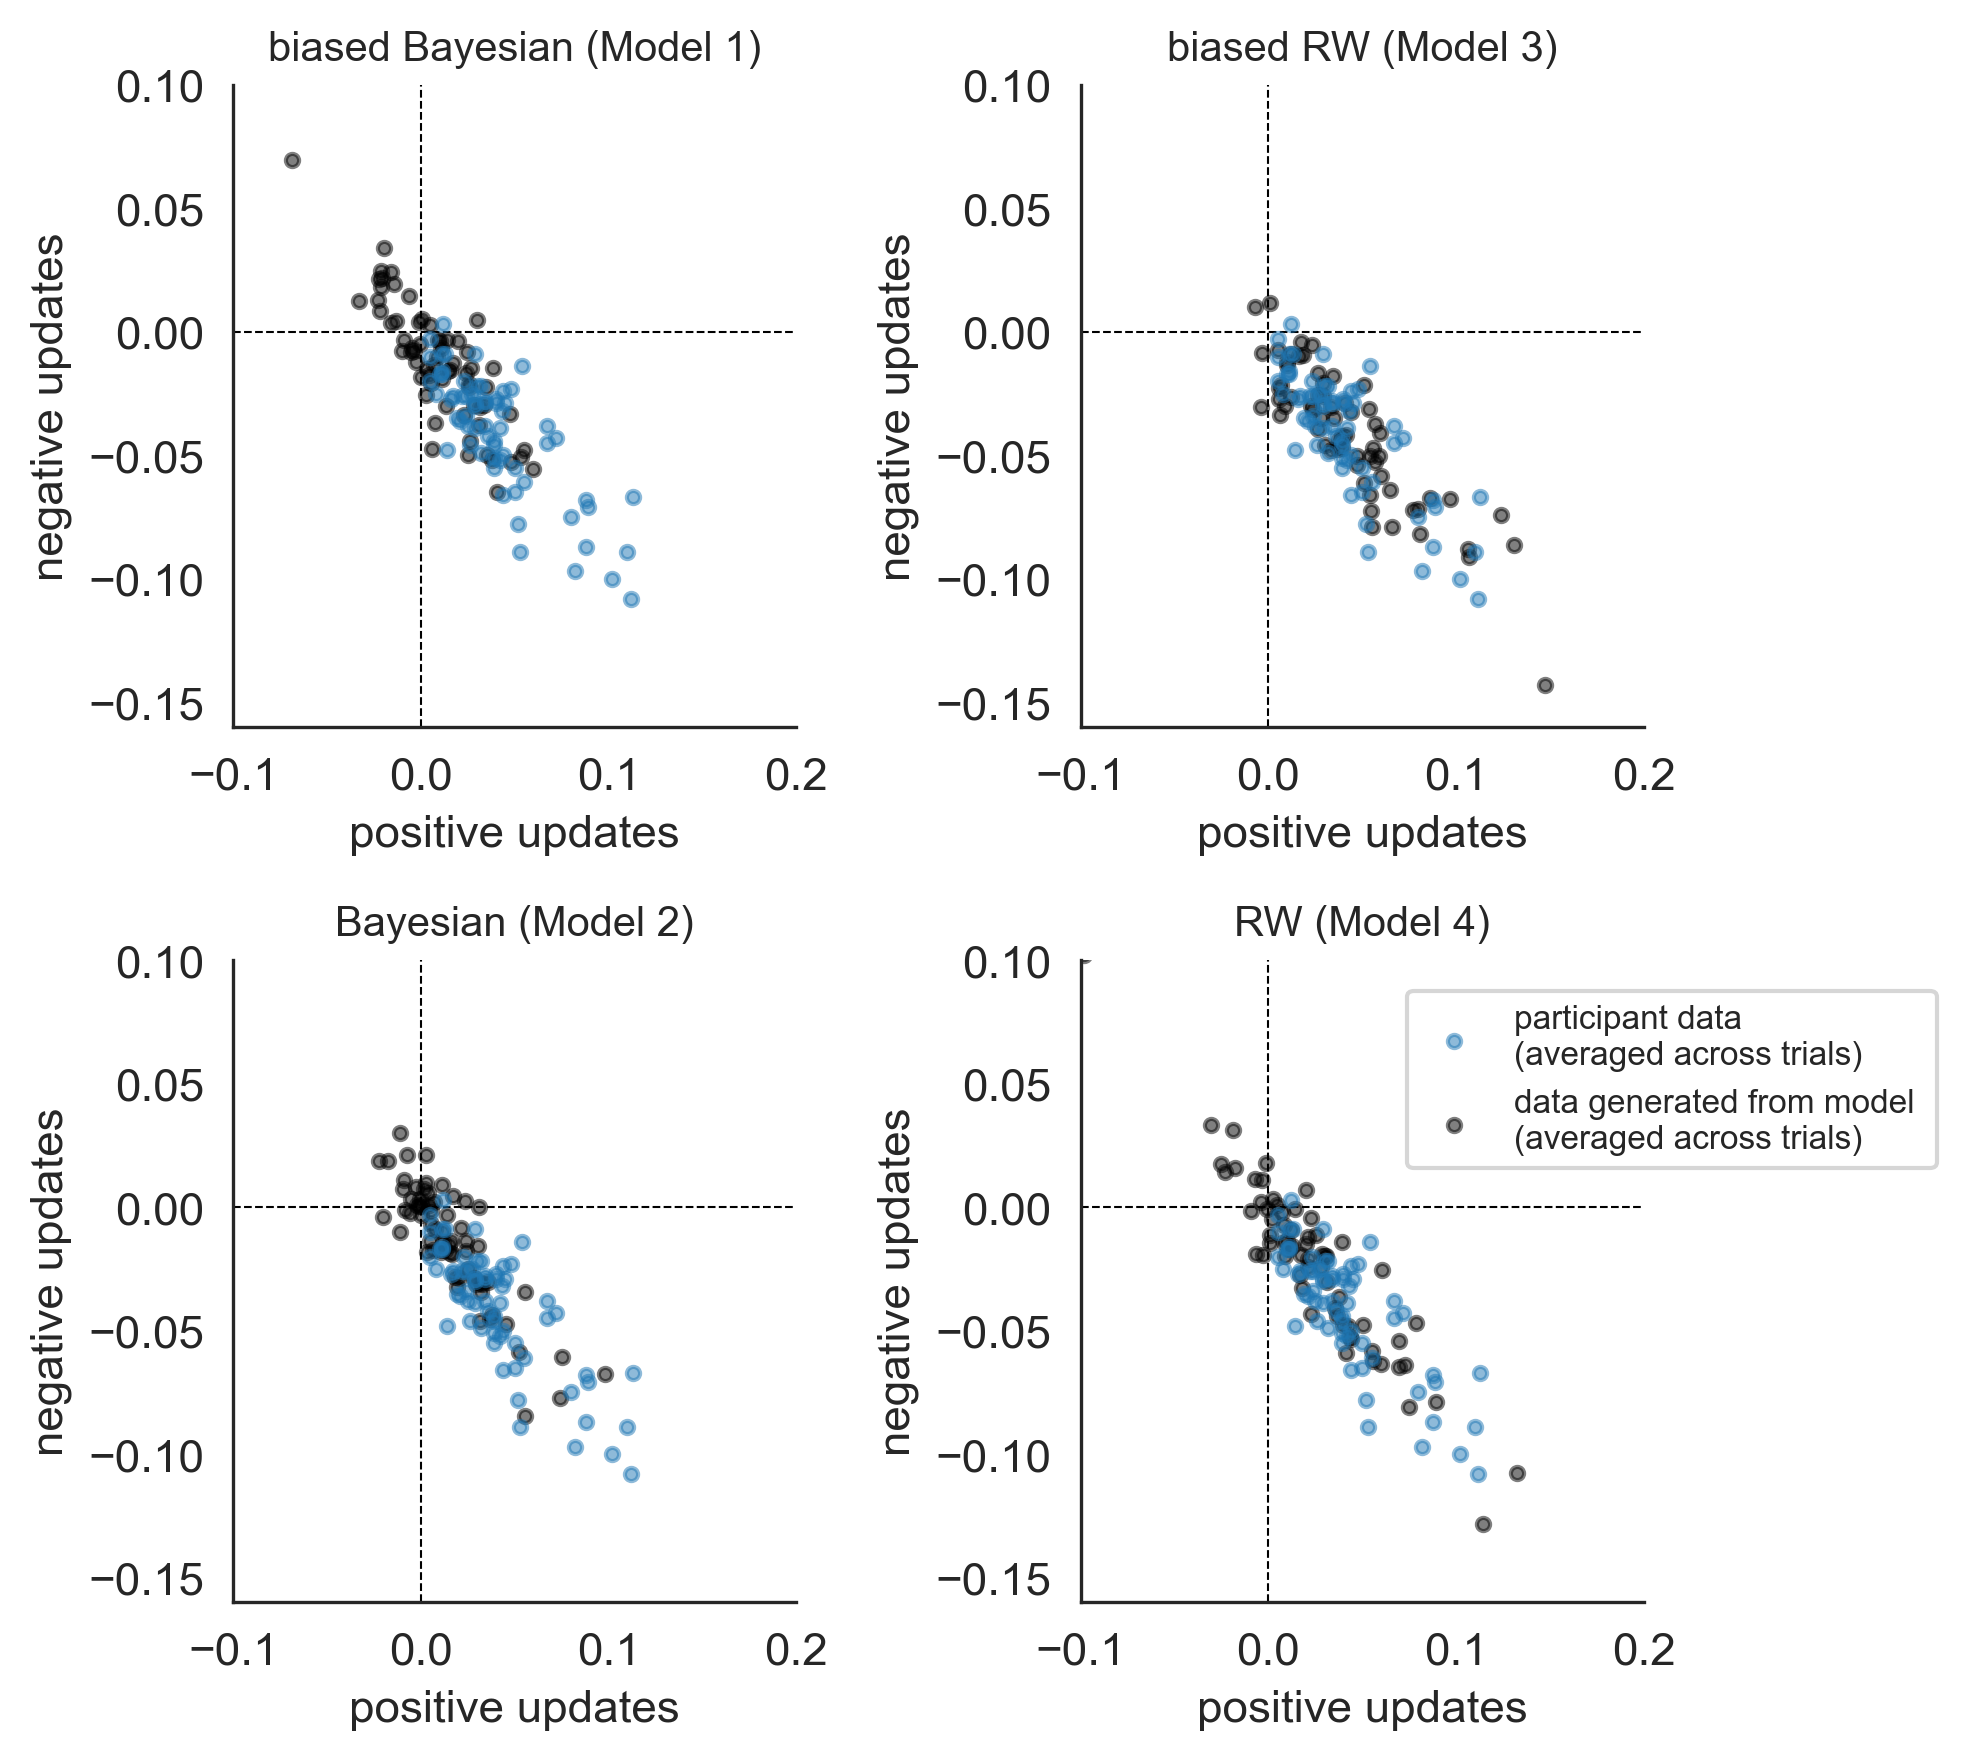

In [21]:
sns.set_style('white')
plt.figure(figsize=(6.5,6),dpi=300, facecolor='w')

plt.subplot(2,2,1)
plt.title(name_replace_modelsA[modelname2],fontsize=labelsize)
plt.scatter(pos_updates2.mean(axis=1),
            neg_updates2.mean(axis=1),s=10,alpha=0.5,
            zorder=2,label='participant data (averaged across trials)')
plt.scatter(new_pos_updates2.mean(axis=2),
            new_neg_updates2.mean(axis=2),
            s=10,color='k',alpha=0.5,label='data generated from model (averaged across trials)')

plt.subplot(2,2,2)

plt.title(name_replace_modelsA[modelname],fontsize=labelsize)
plt.scatter(pos_updates.mean(axis=1),
            neg_updates.mean(axis=1),s=10,alpha=0.5,
            zorder=2,label='individual participant data \n(averaged across trials)')
plt.scatter(new_pos_updates.mean(axis=2),
            new_neg_updates.mean(axis=2),
            s=10,color='k',alpha=0.5,
            label='data generated from models \n(averaged across trials)')


plt.subplot(2,2,3)
plt.title(name_replace_modelsA[modelname3],fontsize=labelsize)
plt.scatter(pos_updates3.mean(axis=1),
            neg_updates3.mean(axis=1),s=10,alpha=0.5,
            zorder=2,label='participant data (averaged across trials)')
plt.scatter(new_pos_updates3.mean(axis=2),
            new_neg_updates3.mean(axis=2),
            s=10,color='k',alpha=0.5,label='data generated from model \n(averaged across trials)')


plt.subplot(2,2,4)
plt.title(name_replace_modelsA[modelname4],fontsize=labelsize)
plt.scatter(pos_updates4.mean(axis=1),
            neg_updates4.mean(axis=1),s=10,alpha=0.5,
            zorder=2,label='participant data \n(averaged across trials)')
plt.scatter(new_pos_updates4.mean(axis=2),
            new_neg_updates4.mean(axis=2),
            s=10,color='k',alpha=0.5,label='data generated from model \n(averaged across trials)')



for i in range(4):
    plt.subplot(2,2,i+1)
    plt.axhline(y=0,color='k',zorder=1,linewidth=0.5,linestyle='--')
    plt.axvline(x=0,color='k',zorder=1,linewidth=0.5,linestyle='--')
    plt.xlabel('positive updates')
    plt.ylabel('negative updates')
    sns.despine()
    plt.xlim([-0.1,0.2])
    plt.ylim([-0.16,0.1])
    if i==3:
        plt.legend(bbox_to_anchor=[0.55,0.65],fontsize=8);
        
plt.tight_layout()
#plt.savefig('../figs_paper_submission/S2.png')
#plt.savefig('../figs_paper_submission/S2.tif')

In [22]:
sys.path.append('../mscl/')
import KS2D

X1 = np.vstack((neg_updates.mean(axis=1),pos_updates.mean(axis=1))).T
X2 = np.vstack((new_neg_updates.mean(axis=2).flatten(),new_pos_updates.mean(axis=2).flatten())).T
print(KS2D.ks2d2s(X1, X2))

X1 = np.vstack((neg_updates2.mean(axis=1),pos_updates2.mean(axis=1))).T
X2 = np.vstack((new_neg_updates2.mean(axis=2).flatten(),new_pos_updates2.mean(axis=2).flatten())).T
print(KS2D.ks2d2s(X1, X2))

X1 = np.vstack((neg_updates3.mean(axis=1),pos_updates3.mean(axis=1))).T
X2 = np.vstack((new_neg_updates3.mean(axis=2).flatten(),new_pos_updates3.mean(axis=2).flatten())).T
print(KS2D.ks2d2s(X1, X2))

X1 = np.vstack((neg_updates4.mean(axis=1),pos_updates4.mean(axis=1))).T
X2 = np.vstack((new_neg_updates4.mean(axis=2).flatten(),new_pos_updates4.mean(axis=2).flatten())).T
print(KS2D.ks2d2s(X1, X2))

(0.18181818181818188, 0.2793697942723653)
(0.5303030303030303, 1.335523702738669e-07)
(0.5227272727272727, 2.027068926663262e-07)
(0.4015151515151515, 0.00012829394320337082)


### Figure S3 - BMS Self

In [23]:
BIC = pd.read_csv('../model_fits/bics_for_model_comparison/full_set_self.csv',skiprows=[0])
BIC.head()

,model_RW_update_w_report_difflr_nofbscaling,model_RW_update_w_report_samelr_fbscaling,model_RW_update_w_report_samelr_nofbscaling,model_RW_update_w_report_samelr_relfbscaling,model_bayes_wreport_asym_no_reported,model_bayes_wreport_basic,model_bayes_wreport_basic_no_reported,model_bayes_wreport_decay_50,model_bayes_wreport_decay_prior,model_bayes_wreport_no_decay,model_bayes_wreport_two_rates_no_decay,model_bayes_wreport_w_no_reported_decay_50,model_bayes_wreport_w_no_reported_decay_prior
0,-82.672,-78.929,-58.890,-81.973,-69.059,-58.903,-61.994,-80.670,-81.884,-83.714,-80.678,-66.014,-66.014
1,-106.108,-103.007,-83.586,-106.033,-84.525,-84.259,-81.984,-103.686,-103.401,-106.522,-103.512,-81.481,-86.902
2,-83.329,-80.528,-78.624,-83.573,-79.633,-71.590,-59.719,-80.668,-80.553,-83.624,-80.577,-76.588,-77.086
3,-59.999,-54.148,-38.915,-57.193,-44.076,-38.881,-43.610,-61.844,-64.775,-56.037,-55.533,-41.031,-41.031
4,-88.370,-86.367,-91.415,-88.372,-70.747,-88.690,-73.543,-85.133,-82.916,-85.972,-82.928,-67.702,-77.383


In [25]:
modelnamelist_renamed = [name_replace_modelsB[modelname] for modelname in modelnamelist]
modelnamelist_renamed

['Model 1',
 'Model 2',
 'Model 3',
 'Model 4',
 'Model 5',
 'Model 6',
 'Model 7',
 'Model 8',
 'Model 9',
 'Model 10',
 'Model 11',
 'Model 12',
 'Model 13']

In [26]:
bms_results = pd.read_csv('../model_fits/bics_for_model_comparison/full_set_self_results.csv')
bms_results['modelname']=BIC.columns
bms_results['modelname_for_plot']=[name_replace_modelsB[modelname] for modelname in bms_results['modelname'].values]
bms_results['model class']=['Bayesian' if 'ayes' in modelname else 'RW' for modelname in bms_results.modelname]
bms_results=bms_results.sort_values('modelname',ascending=False)
bms_results.head(14)

,alpha,exp_r,xp,pxp,modelname,modelname_for_plot,model class
12,1.353610,0.017134,0.000000,8.149388e-08,model_bayes_wreport_w_no_reported_decay_prior,Model 8,Bayesian
11,1.061076,0.013431,0.000000,8.149388e-08,model_bayes_wreport_w_no_reported_decay_50,Model 7,Bayesian
10,6.160587,0.077982,0.001474,1.474080e-03,model_bayes_wreport_two_rates_no_decay,Model 13,Bayesian
9,14.868122,0.188204,0.251184,2.511838e-01,model_bayes_wreport_no_decay,Model 10,Bayesian
8,2.944418,0.037271,0.000022,2.208147e-05,model_bayes_wreport_decay_prior,Model 12,Bayesian
7,4.935787,0.062478,0.000391,3.910811e-04,model_bayes_wreport_decay_50,Model 11,Bayesian
6,1.419288,0.017966,0.000000,8.149388e-08,model_bayes_wreport_basic_no_reported,Model 2,Bayesian
5,1.867880,0.023644,0.000003,3.081491e-06,model_bayes_wreport_basic,Model 9,Bayesian
4,1.029234,0.013028,0.000000,8.149388e-08,model_bayes_wreport_asym_no_reported,Model 1,Bayesian
3,18.206487,0.230462,0.671509,6.715084e-01,model_RW_update_w_report_samelr_relfbscaling,Model 3,RW


In [29]:
bms_results.modelname_for_plot = bms_results.modelname_for_plot.astype("category")
bms_results.modelname_for_plot.cat.set_categories(modelnamelist_renamed, inplace=True)
bms_results.sort_values('modelname_for_plot',inplace=True)

mclass= bms_results['model class'].values
color = [sns.color_palette()[1] if mc == 'RW' else sns.color_palette()[0] for mc in mclass]

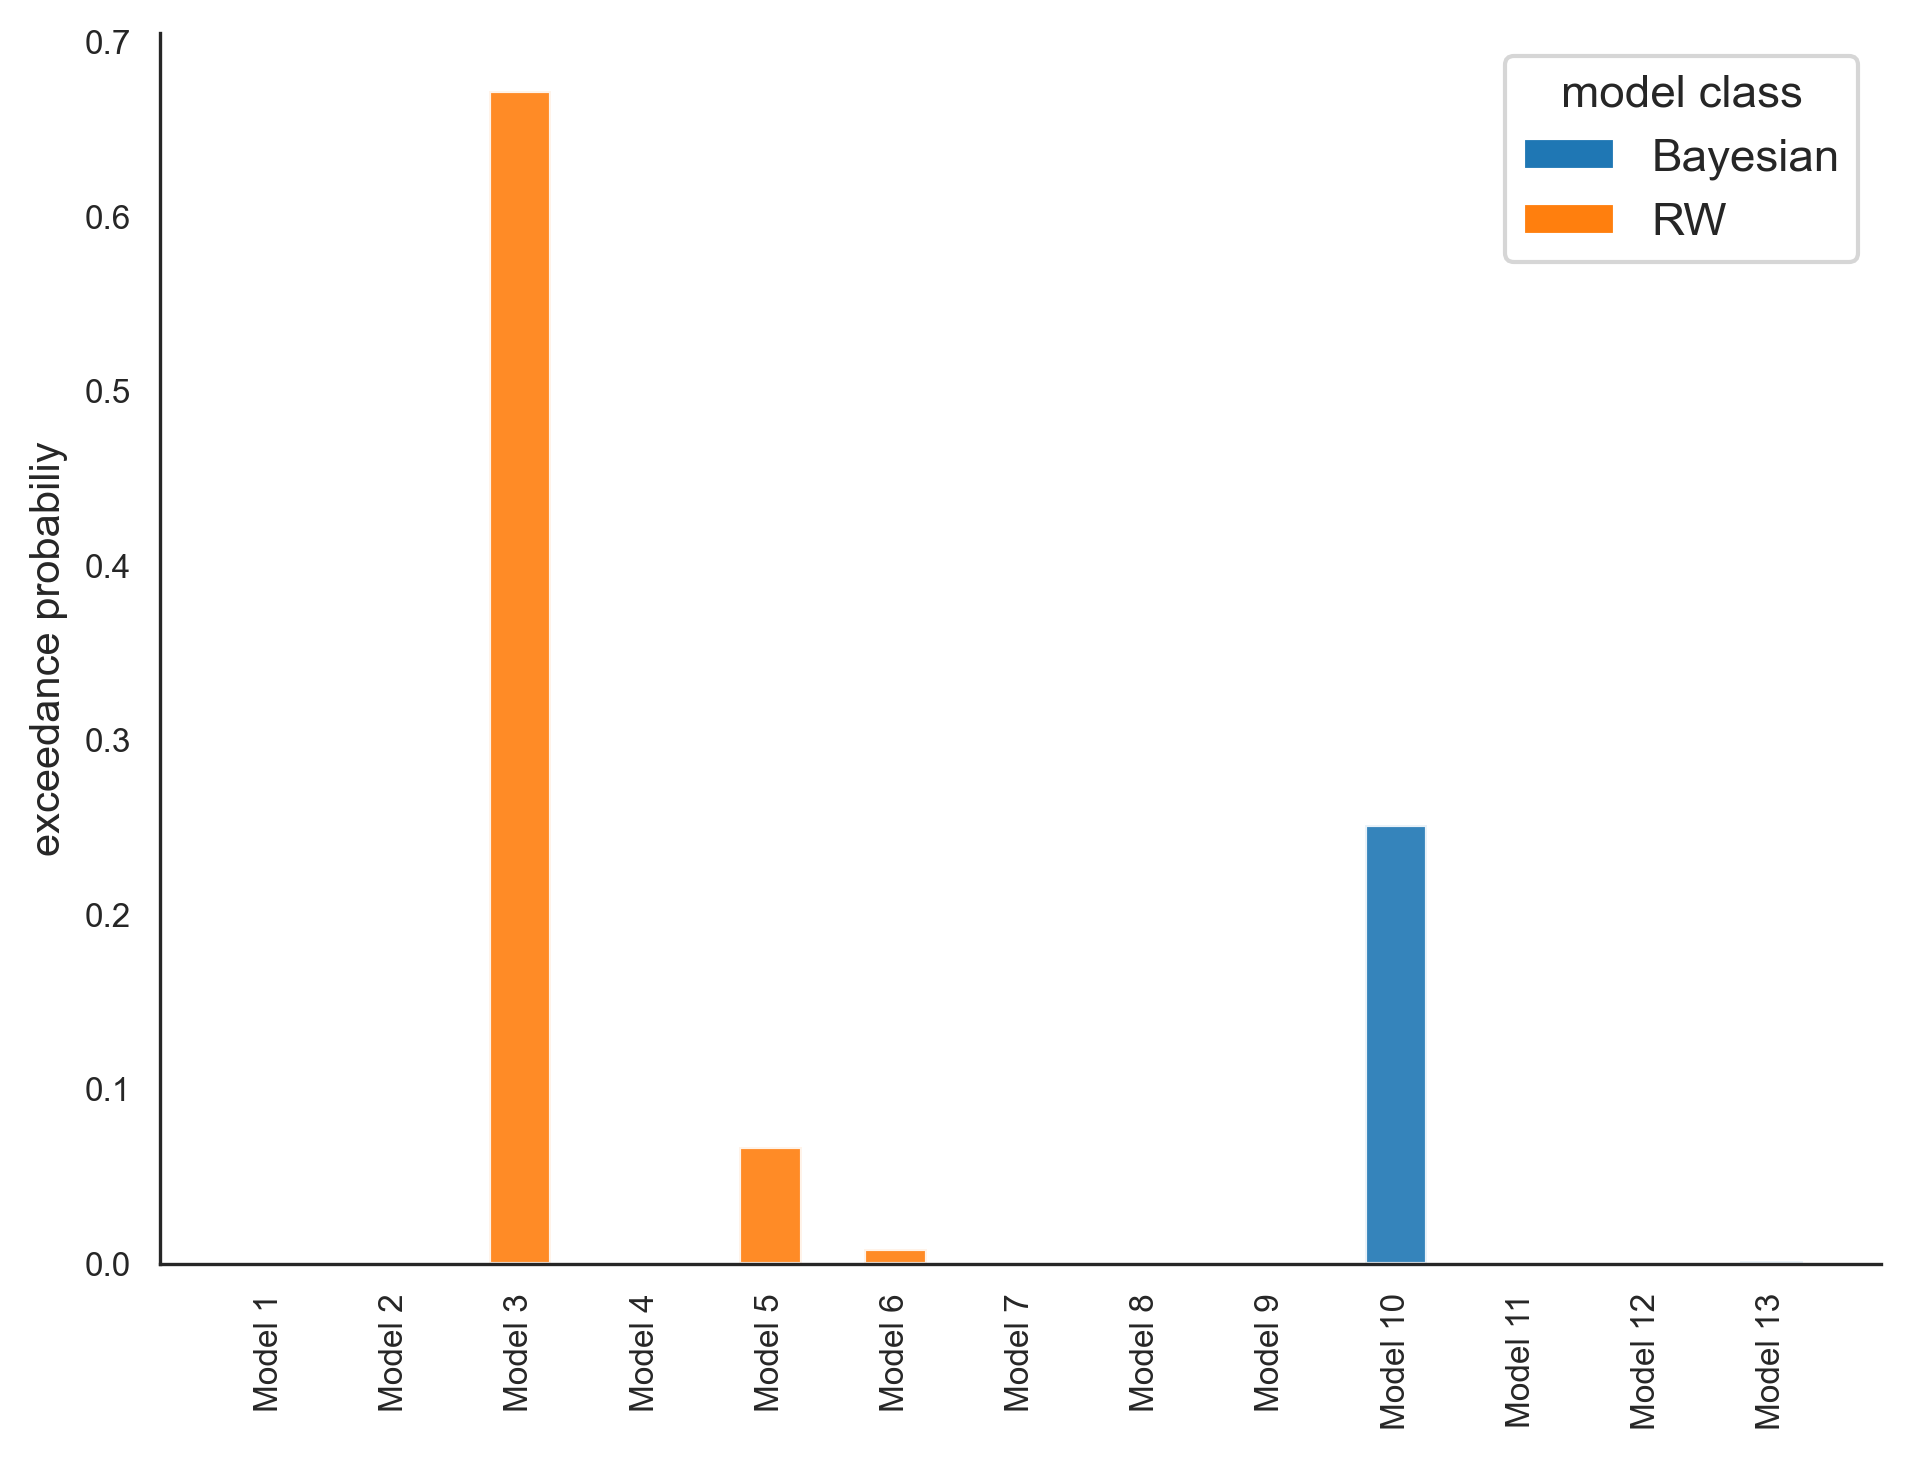

In [30]:
fs = 8

xticklabels = bms_results['modelname_for_plot'].values
y = bms_results['pxp']
x = np.arange(len(y))

plt.figure(figsize=(6.5,5),dpi=300, facecolor='w')

plt.bar(x,y,color=color,alpha=0.9,width=0.5)

plt.ylabel('exceedance probabiliy',fontsize=fs+2)
sns.despine()
plt.xlabel(None)
ax=plt.gca()
plt.xticks(x,xticklabels,rotation=90,fontsize=fs)
plt.yticks(fontsize=fs)
plt.setp(ax.get_xticklabels(),ha='center',va="top",rotation_mode="default")

from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=sns.color_palette()[0], edgecolor=None,
                         label='Bayesian'),
                  Patch(facecolor=sns.color_palette()[1], edgecolor=None,
                         label='RW')]
plt.legend(handles=legend_elements,title='model class')

plt.tight_layout()
#plt.savefig('../figs_paper_submission/S3.png')
#plt.savefig('../figs_paper_submission/S3.tif')

### Figure S4 - Confusion Matrix

In [32]:
perc_corr_selected = np.load('../data_for_gen_recover_analysis/perc_corr_selected_allsmall_10_16_19_priors2_modelrec.npy')

In [33]:
new_order = np.array([1,0,10,9,11,12,2,3,4,5,6,7,8])
perc_corr_selected = perc_corr_selected[new_order,:,:][:,:,new_order]
perc_corr_selected_avg = np.round(perc_corr_selected.mean(axis=1),2)

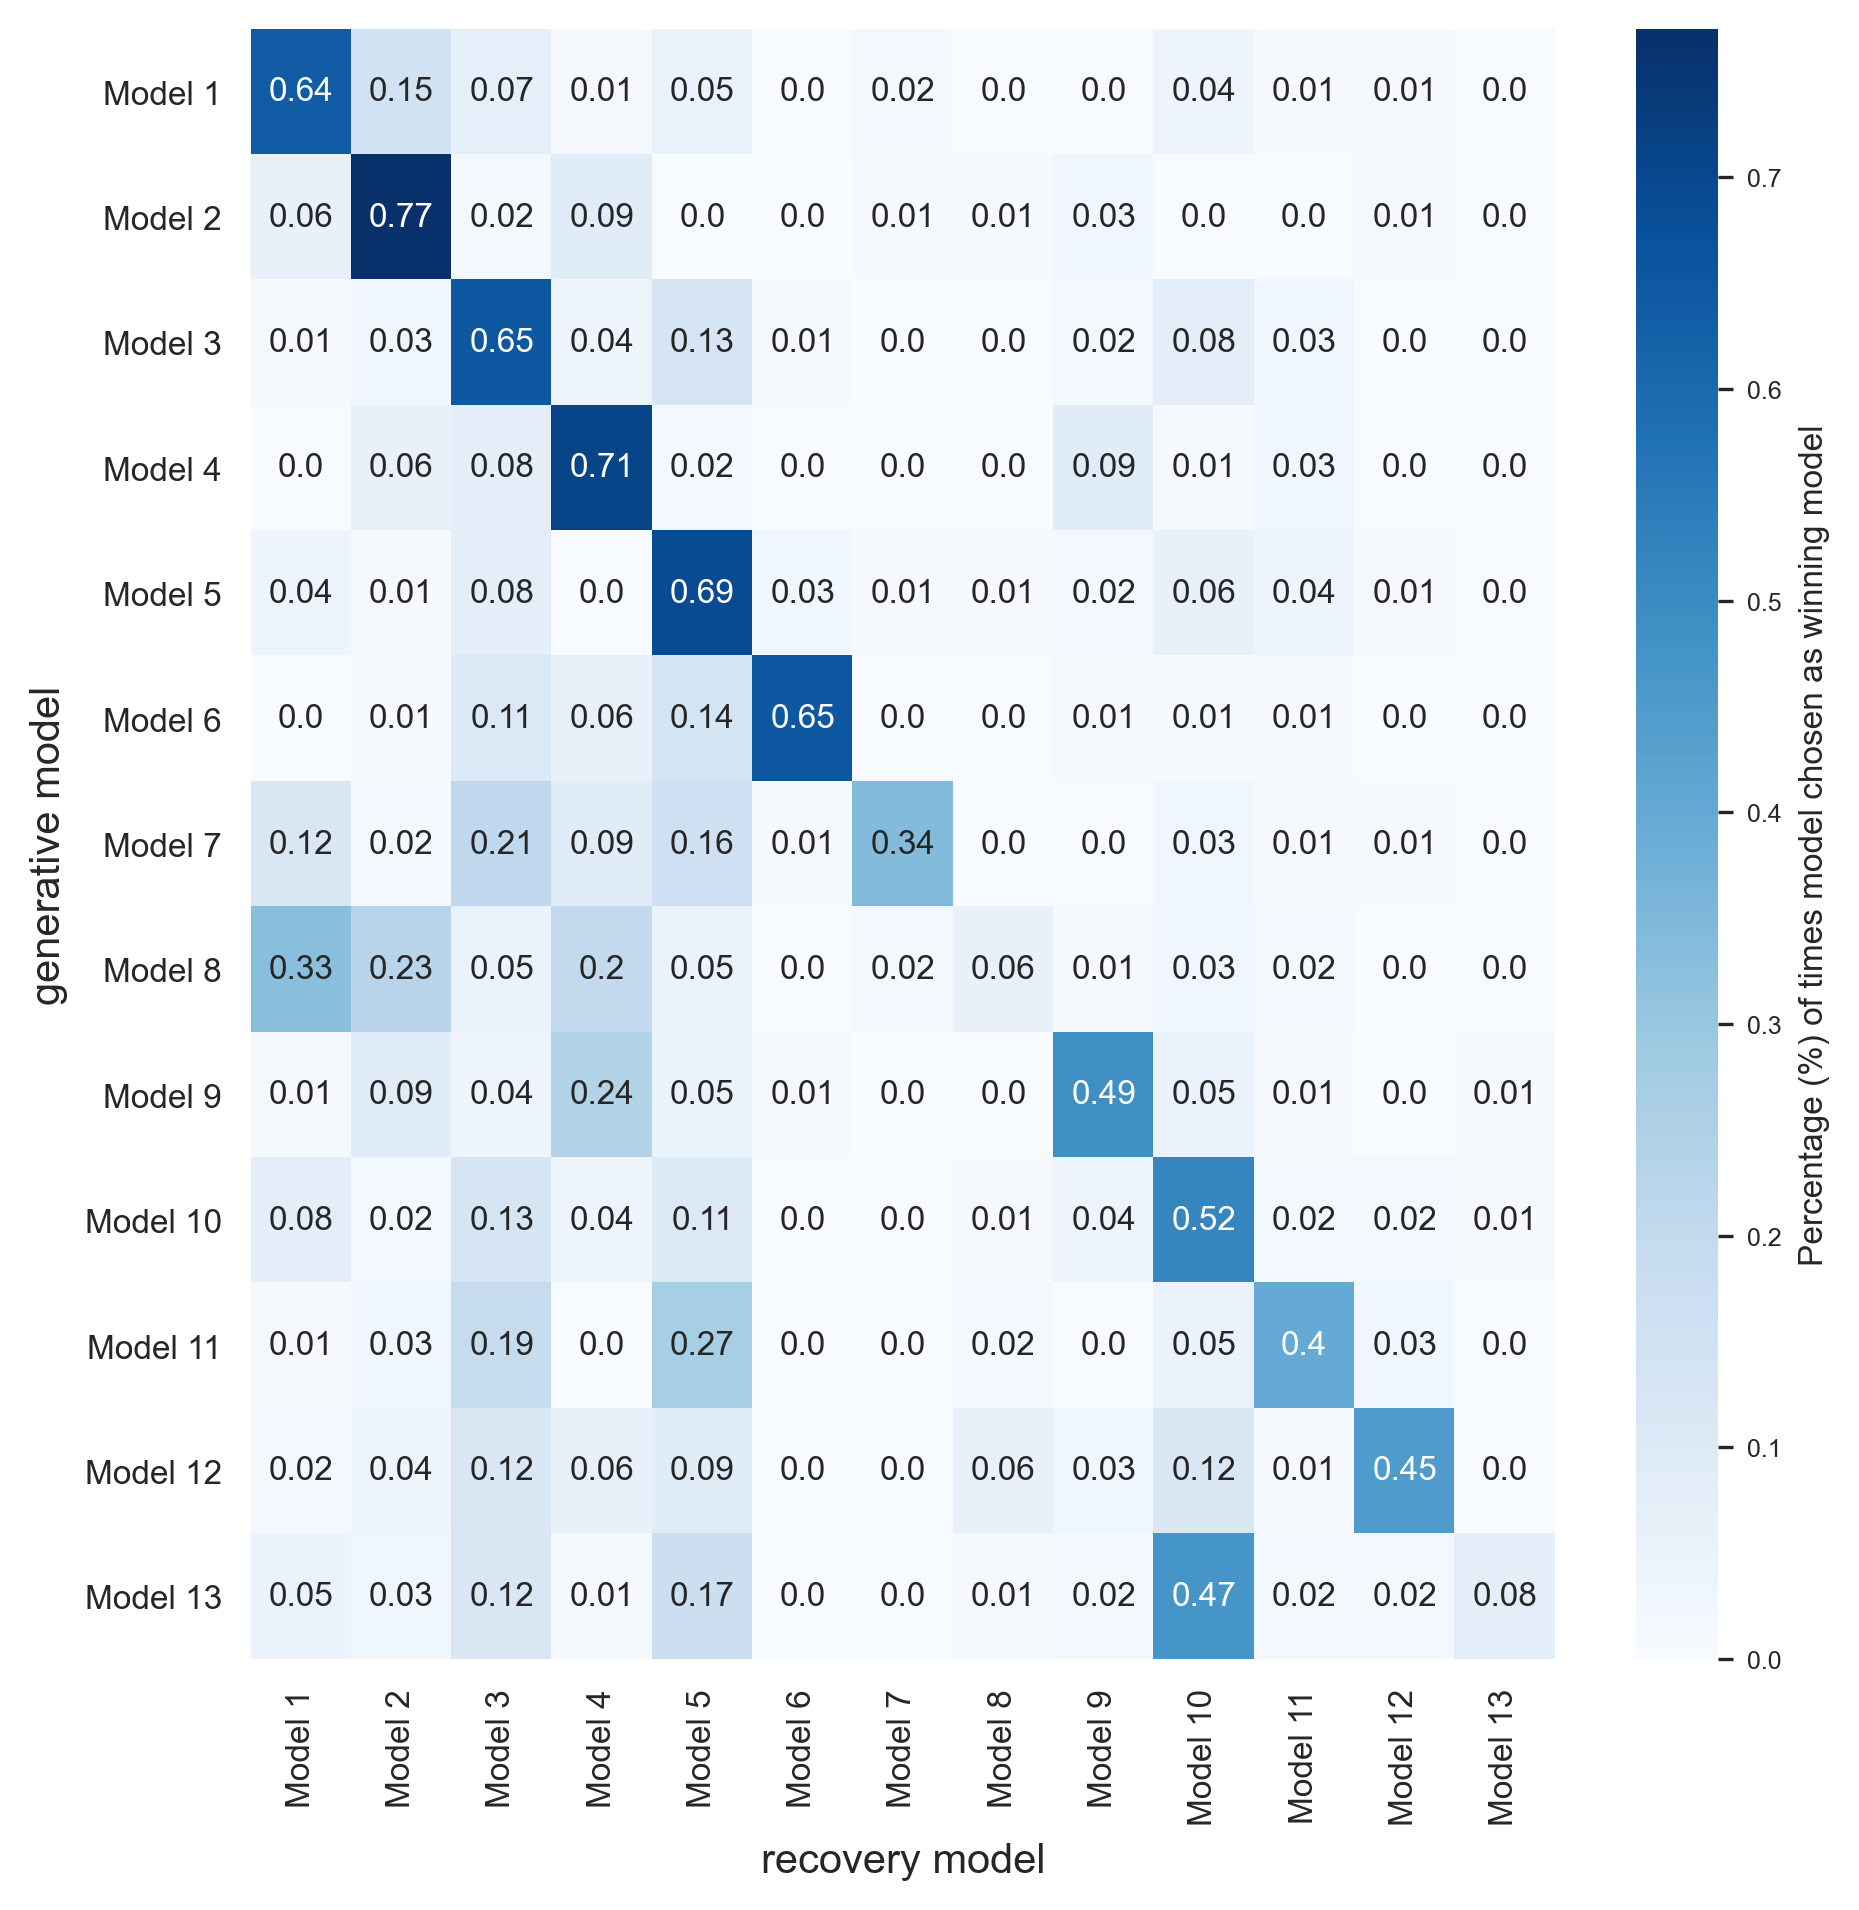

In [34]:

plt.figure(figsize=(6.5,6.5),dpi=300, facecolor='w')
ax = sns.heatmap(perc_corr_selected_avg,
                 annot=perc_corr_selected_avg.astype('str'),fmt='s',
                 cmap="Blues",
                 annot_kws = {'fontsize':8},
                 cbar_kws ={'label':'Percentage (%) of times model chosen as winning model'})

#plt.title('Model recovery simulations')
plt.ylabel('generative model',fontsize=labelsize)
plt.xlabel('recovery model',fontsize=labelsize)
plt.xticks(np.arange(len(modelnamelist_renamed))+0.5,modelnamelist_renamed,rotation=90,fontsize=ticklabelsize);
plt.yticks(np.arange(len(modelnamelist_renamed))+0.5,modelnamelist_renamed,rotation=0,fontsize=ticklabelsize);

cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(8)
cbar_axes.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
#plt.savefig('../figs_paper_submission/S4.png')
#plt.savefig('../figs_paper_submission/S4.tif')

### Figure S5 - Other parameter plots

In [35]:
modelname ='model_RW_update_w_report_samelr_relfbscaling'
model_fits_df, params = get_model_fit_data(modelname, df)

/Users/chrisgagne/opt/miniconda3/envs/env_belief_updating/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chrisgagne/opt/miniconda3/envs/env_belief_updating/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chrisgagne/opt/miniconda3/envs/env_belief_updating/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing 

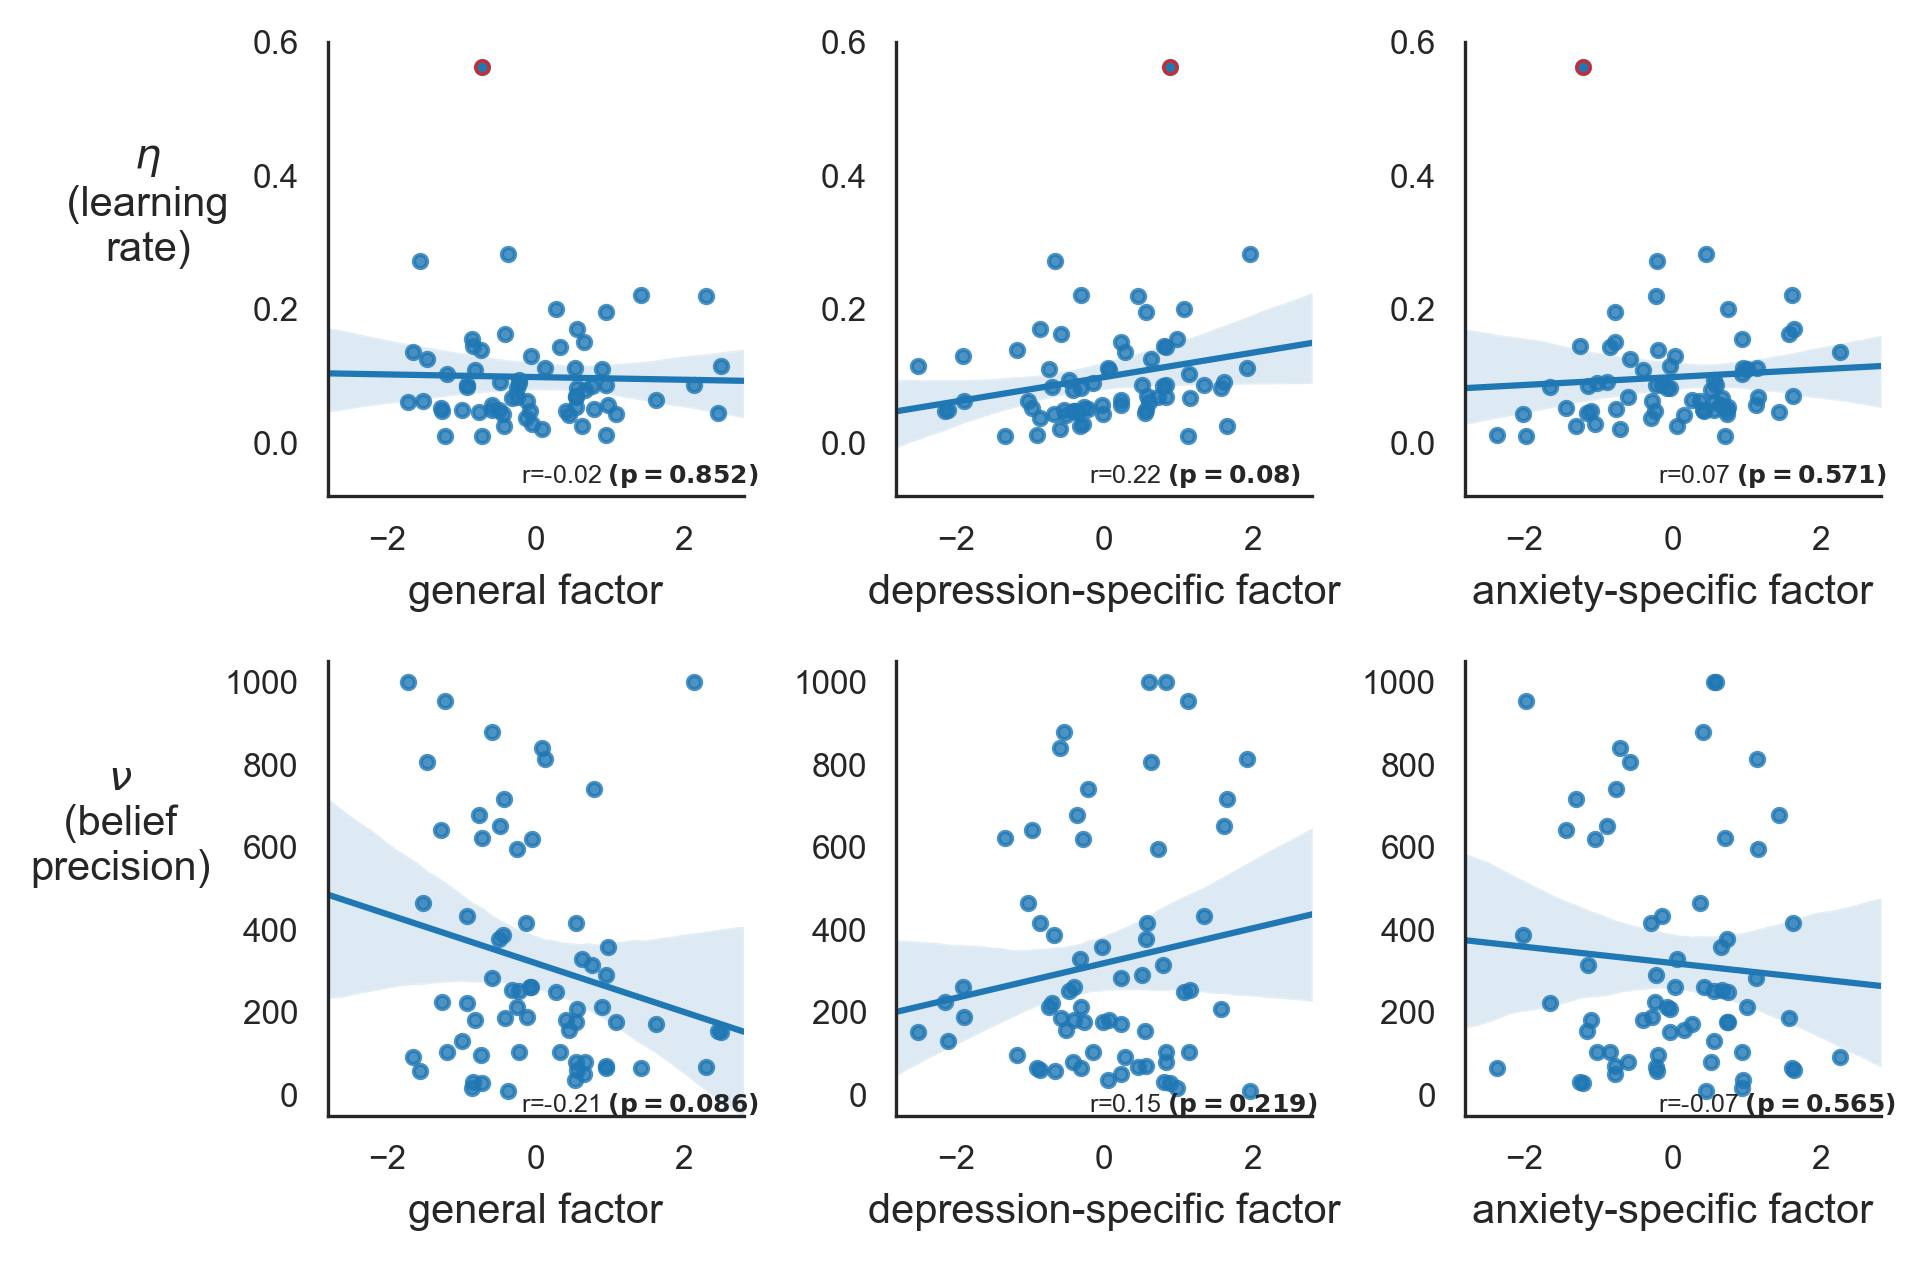

In [36]:
plt.figure(figsize=(6.5,6.5*(2/3)),dpi=300, facecolor='w')

i = 0
for si,stat in enumerate(['alpha','v_s',]):
    for ti,trait in enumerate([
        'item_clinical.fa.omega3.g',
        'item_clinical.fa.omega3.anh',
        'item_clinical.fa.omega3.cog_anx',]):

        plt.subplot(2,3,i+1)
        plt.xlim([-2.8,2.8])
            
        y = model_fits_df[stat].values
        
        if stat=='alpha':
            plt.ylim([-0.08,0.6])
        elif stat=='v_s':
            plt.ylim([-50,1050])
          
            
            
        # plot scatter
        x = model_fits_df[trait].values

        # exclude outlier
#         if stat=='alpha':
#             sel = y<0.5
#             y = y[sel]
#             x = x[sel]
        
        sns.regplot(x,y,scatter_kws={'zorder':3,'s':10},line_kws={'linewidth':1.5},truncate=False)

        plt.xlabel(name_replace_clinical[trait],fontsize=labelsize)
        
        # correlations 
        sr,sp = spearmanr(x,y)
        sr = np.round(sr,2)
        sp = np.round(sp,3)
        #pr,pp = pearsonr(x,y)
        pp,pr,_,_,_ = pearson_permutation_test(x,y)
        
        pr = np.round(pr,2)
        pp = np.round(pp,3)
        #exclude outlier
        if stat=='alpha':
            sel = y<0.5
            plt.scatter(x[~sel],y[~sel],fc=sns.color_palette()[0],
                        ec=sns.color_palette()[3],s=10,zorder=4,linewidth=.75)
        pr_noout,pp_noout = pearsonr(x[sel],y[sel])
        pr_noout = np.round(pr_noout,2)
        pp_noout = np.round(pp_noout,3)
        
            
        # x and y labels 
        if ti==0:
            stat_replaced = name_replace_stat[stat]
            plt.ylabel(stat_replaced,fontsize=labelsize,rotation=0,labelpad=25)
            
        sns.despine()
        ax=plt.gca()
        ax.tick_params(axis='both', which='major', labelsize=ticklabelsize)

        if stat=='alpha':
            xy=(-0.2,-0.06)
        if stat=='v_s':
            xy=(-0.2,-40)

        plt.annotate('r='+str(pr)+r" $\bf{(p="+str(pp)+r")}$",xy=xy,fontsize=6)
        
        if ti==0:
            if i==0:
                plt.ylabel(stat_replaced + '\n (learning \nrate)',fontsize=labelsize,rotation=0,labelpad=25)
            else:
                plt.ylabel(stat_replaced + '\n (belief \nprecision)',fontsize=labelsize,rotation=0,labelpad=25)

        
        i+=1
        
plt.tight_layout()
#plt.savefig('../figs_paper_submission/S5.png')
#plt.savefig('../figs_paper_submission/S5.tif')

### Figure S6 - BMS Other

In [37]:
BIC = pd.read_csv('../model_fits/bics_for_model_comparison/full_set_other.csv',skiprows=[0])
BIC.head()

,model_RW_update_w_report_difflr_nofbscaling,model_RW_update_w_report_samelr_fbscaling,model_RW_update_w_report_samelr_nofbscaling,model_RW_update_w_report_samelr_relfbscaling,model_bayes_wreport_asym_no_reported,model_bayes_wreport_basic,model_bayes_wreport_basic_no_reported,model_bayes_wreport_decay_50,model_bayes_wreport_decay_prior,model_bayes_wreport_no_decay,model_bayes_wreport_two_rates_no_decay,model_bayes_wreport_w_no_reported_decay_50,model_bayes_wreport_w_no_reported_decay_prior
0,-84.046,-81.889,-65.444,-84.795,-71.451,-65.682,-68.595,-80.885,-78.861,-81.891,-78.849,-68.406,-67.319
1,-82.592,-79.547,-84.358,-82.590,-78.758,-85.315,-81.769,-80.162,-80.040,-83.206,-80.163,-75.713,-75.713
2,-59.966,-56.886,-61.494,-59.930,-61.173,-62.069,-64.046,-57.418,-58.475,-60.462,-57.417,-58.129,-58.117
3,-58.918,-57.667,-25.337,-60.711,-46.526,-24.873,-22.465,-56.255,-49.538,-52.582,-49.707,-43.481,-43.481
4,-88.895,-85.913,-90.598,-88.891,-64.968,-89.680,-62.334,-89.171,-88.412,-89.507,-86.471,-61.924,-61.924


In [38]:
modelnamelist_renamed = [name_replace_modelsB[modelname] for modelname in modelnamelist]
modelnamelist_renamed

['Model 1',
 'Model 2',
 'Model 3',
 'Model 4',
 'Model 5',
 'Model 6',
 'Model 7',
 'Model 8',
 'Model 9',
 'Model 10',
 'Model 11',
 'Model 12',
 'Model 13']

In [39]:
bms_results = pd.read_csv('../model_fits/bics_for_model_comparison/full_set_other_results.csv')
bms_results['modelname']=BIC.columns
bms_results['modelname_for_plot']=[name_replace_modelsB[modelname] for modelname in bms_results['modelname'].values]
bms_results['model class']=['Bayesian' if 'ayes' in modelname else 'RW' for modelname in bms_results.modelname]
bms_results=bms_results.sort_values('modelname',ascending=False)
bms_results.head(14)

,alpha,exp_r,xp,pxp,modelname,modelname_for_plot,model class
12,1.031809,0.013061,0.000000,1.656079e-09,model_bayes_wreport_w_no_reported_decay_prior,Model 8,Bayesian
11,1.053350,0.013334,0.000000,1.656079e-09,model_bayes_wreport_w_no_reported_decay_50,Model 7,Bayesian
10,1.024525,0.012969,0.000000,1.656079e-09,model_bayes_wreport_two_rates_no_decay,Model 13,Bayesian
9,4.687394,0.059334,0.000032,3.200166e-05,model_bayes_wreport_no_decay,Model 10,Bayesian
8,13.207588,0.167185,0.052510,5.251000e-02,model_bayes_wreport_decay_prior,Model 12,Bayesian
7,3.146811,0.039833,0.000003,3.001656e-06,model_bayes_wreport_decay_50,Model 11,Bayesian
6,4.842954,0.061303,0.000059,5.900165e-05,model_bayes_wreport_basic_no_reported,Model 2,Bayesian
5,3.923864,0.049669,0.000018,1.800166e-05,model_bayes_wreport_basic,Model 9,Bayesian
4,1.353264,0.017130,0.000000,1.656079e-09,model_bayes_wreport_asym_no_reported,Model 1,Bayesian
3,20.481673,0.259262,0.620820,6.208200e-01,model_RW_update_w_report_samelr_relfbscaling,Model 3,RW


In [40]:
bms_results.modelname_for_plot = bms_results.modelname_for_plot.astype("category")
bms_results.modelname_for_plot.cat.set_categories(modelnamelist_renamed, inplace=True)
bms_results.sort_values('modelname_for_plot',inplace=True)

mclass= bms_results['model class'].values
color = [sns.color_palette()[1] if mc == 'RW' else sns.color_palette()[0] for mc in mclass]

/Users/chrisgagne/opt/miniconda3/envs/env_belief_updating/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


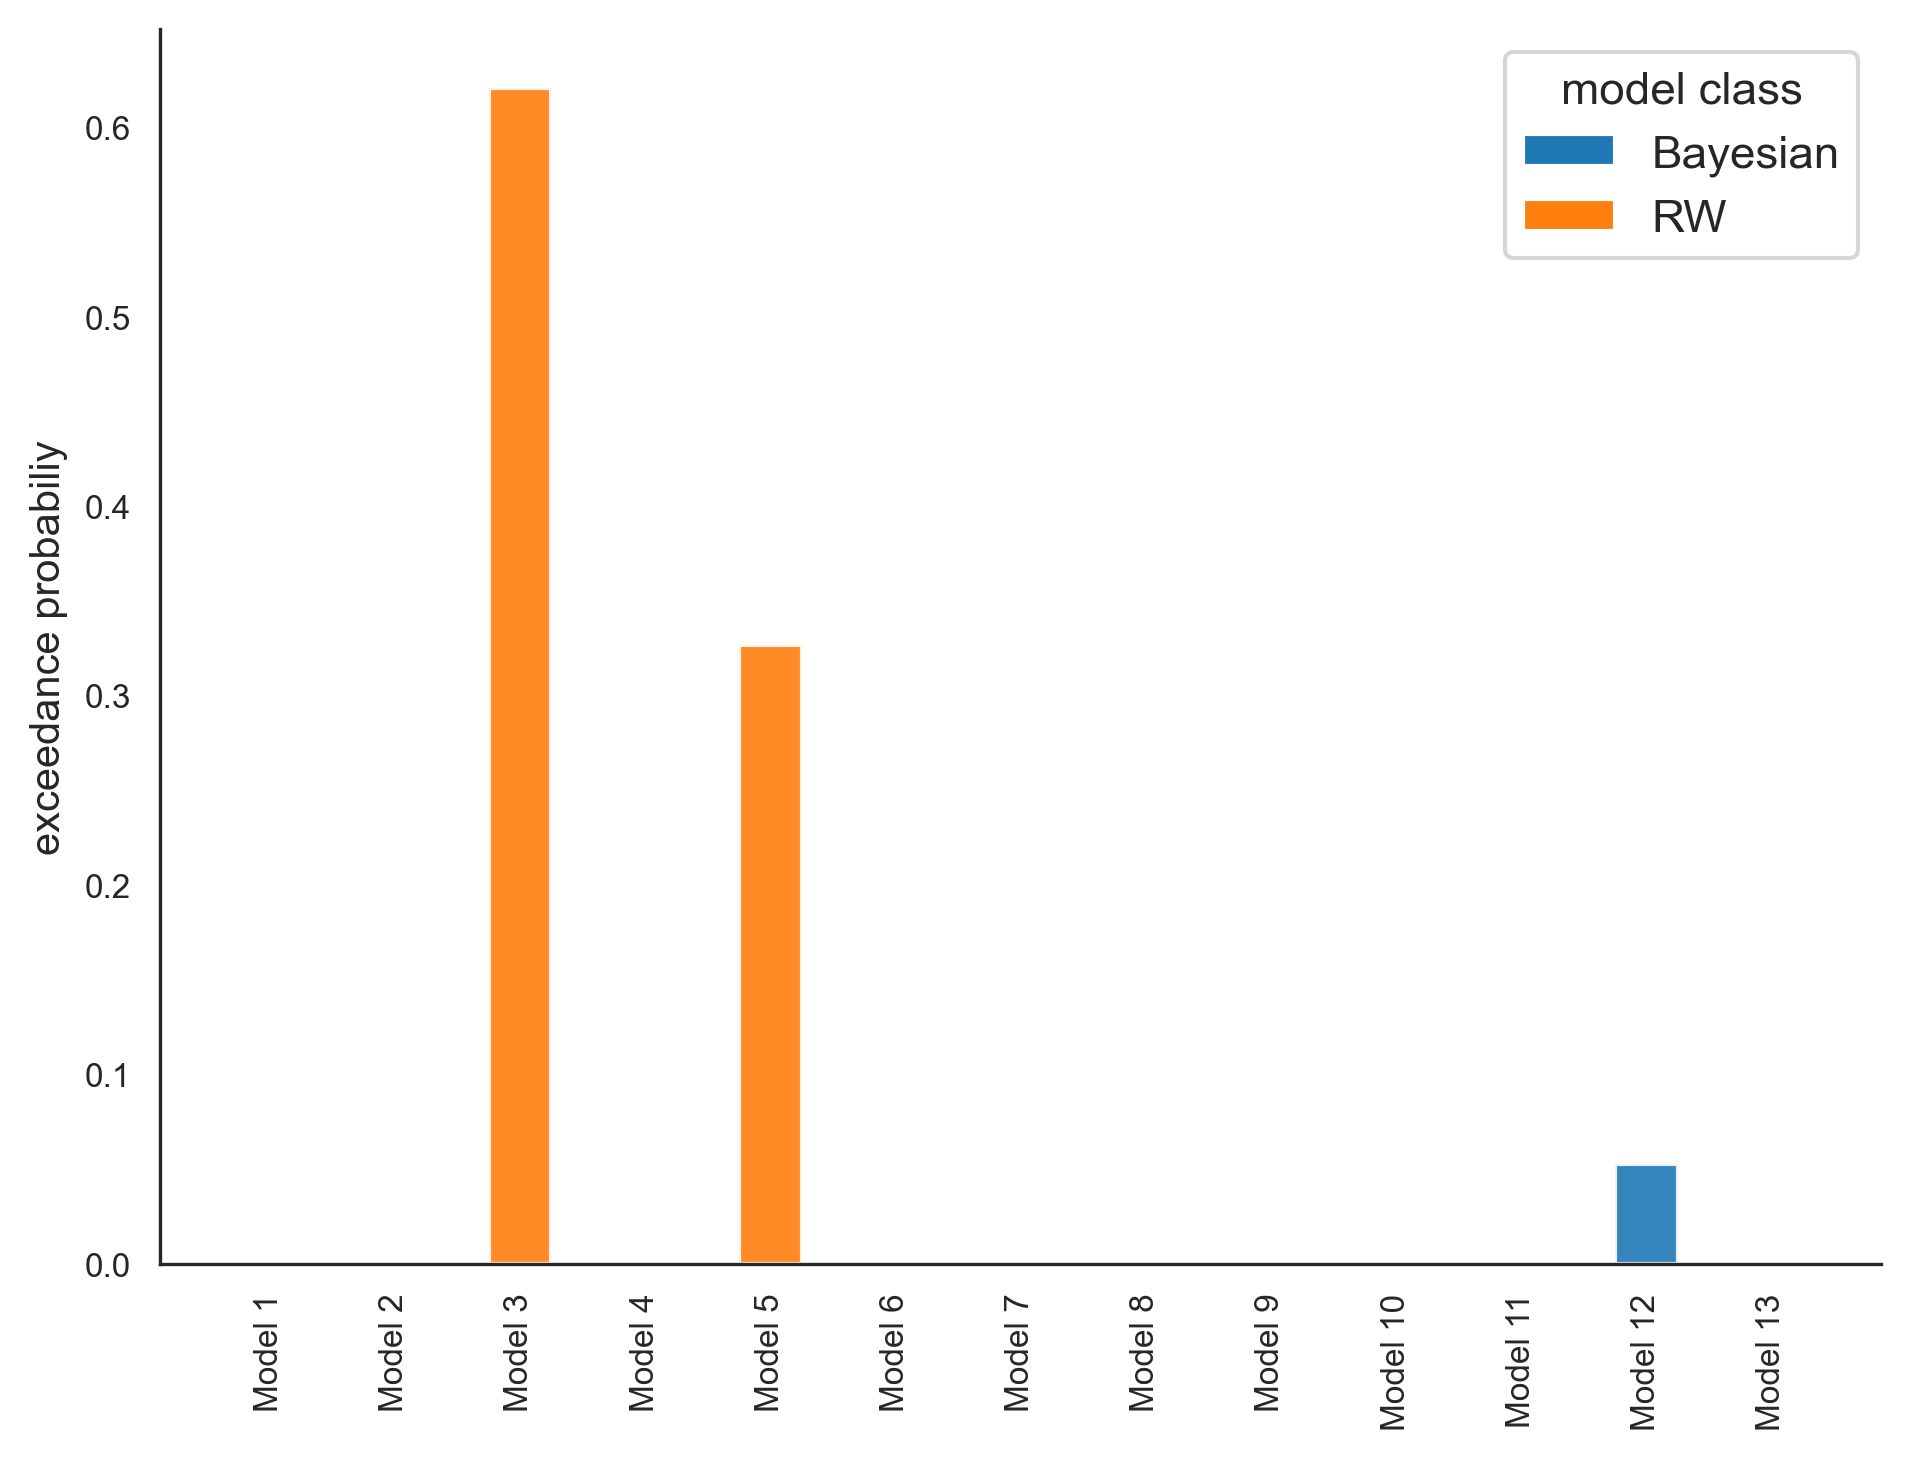

In [41]:
fs = 8

xticklabels = bms_results['modelname_for_plot'].values
y = bms_results['pxp']
x = np.arange(len(y))

plt.figure(figsize=(6.5,5),dpi=300, facecolor='w')

plt.bar(x,y,color=color,alpha=0.9,width=0.5)

plt.ylabel('exceedance probabiliy',fontsize=fs+2)
sns.despine()
plt.xlabel(None)
ax=plt.gca()
plt.xticks(x,xticklabels,rotation=90,fontsize=fs)
plt.yticks(fontsize=fs)
plt.setp(ax.get_xticklabels(),ha='center',va="top",rotation_mode="default")

from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=sns.color_palette()[0], edgecolor=None,
                         label='Bayesian'),
                  Patch(facecolor=sns.color_palette()[1], edgecolor=None,
                         label='RW')]
plt.legend(handles=legend_elements,title='model class')

plt.tight_layout()
#plt.savefig('../figs_paper_submission/S6.png')
#plt.savefig('../figs_paper_submission/S6.tif')

### Figure S7 - Model Agnostic Statistics

In [42]:
traits = [
    'stai_state_sess3','stai_trait_anx_sess2',
                  'stai_trait_anx_sess3','stai_trait_dep_sess2','stai_trait_dep_sess3',
                  'cesd_dep_sess2', 'cesd_dep_sess3',
                  'cesd_anh_sess2','cesd_anh_sess3',
                  'cesd_som_sess2','cesd_som_sess3',
                 'masq_aa','masq_ad','masq_as','masq_ds','pswq']
                  
dftmp = df[traits]
dftmp['end - start belief']=[df['self_estimate_flipped'][i][-1] for i in range(len(df))]-df['starting_beliefs_self']
dftmp['ending belief']=[df['self_estimate_flipped'][i][-1] for i in range(len(df))]
dftmp['starting belief']=df['starting_beliefs_self']
dftmp.corr()
metrics = ['starting belief','end - start belief','ending belief']
C = pd.DataFrame(np.round(dftmp.corr()[metrics],2))

C_w_p = C.copy()
C_w_p = C_w_p.astype('str')
for trait in C.index:
    for metric in C.columns:
        x = dftmp[trait].values
        y = dftmp[metric].values
        r,p = pearsonr(x,y)
        C_w_p.loc[trait,metric]=''+str(round(r,2))+'\n('+str(round(p,2))+')'
  
C_w_p.head()

/Users/chrisgagne/opt/miniconda3/envs/env_belief_updating/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,starting belief,end - start belief,ending belief
stai_state_sess3,0.02\n(0.87),-0.03\n(0.8),-0.01\n(0.97)
stai_trait_anx_sess2,-0.23\n(0.06),0.05\n(0.7),-0.2\n(0.11)
stai_trait_anx_sess3,-0.04\n(0.76),-0.04\n(0.73),-0.08\n(0.54)
stai_trait_dep_sess2,-0.28\n(0.02),-0.04\n(0.77),-0.33\n(0.01)
stai_trait_dep_sess3,-0.27\n(0.03),-0.04\n(0.74),-0.32\n(0.01)


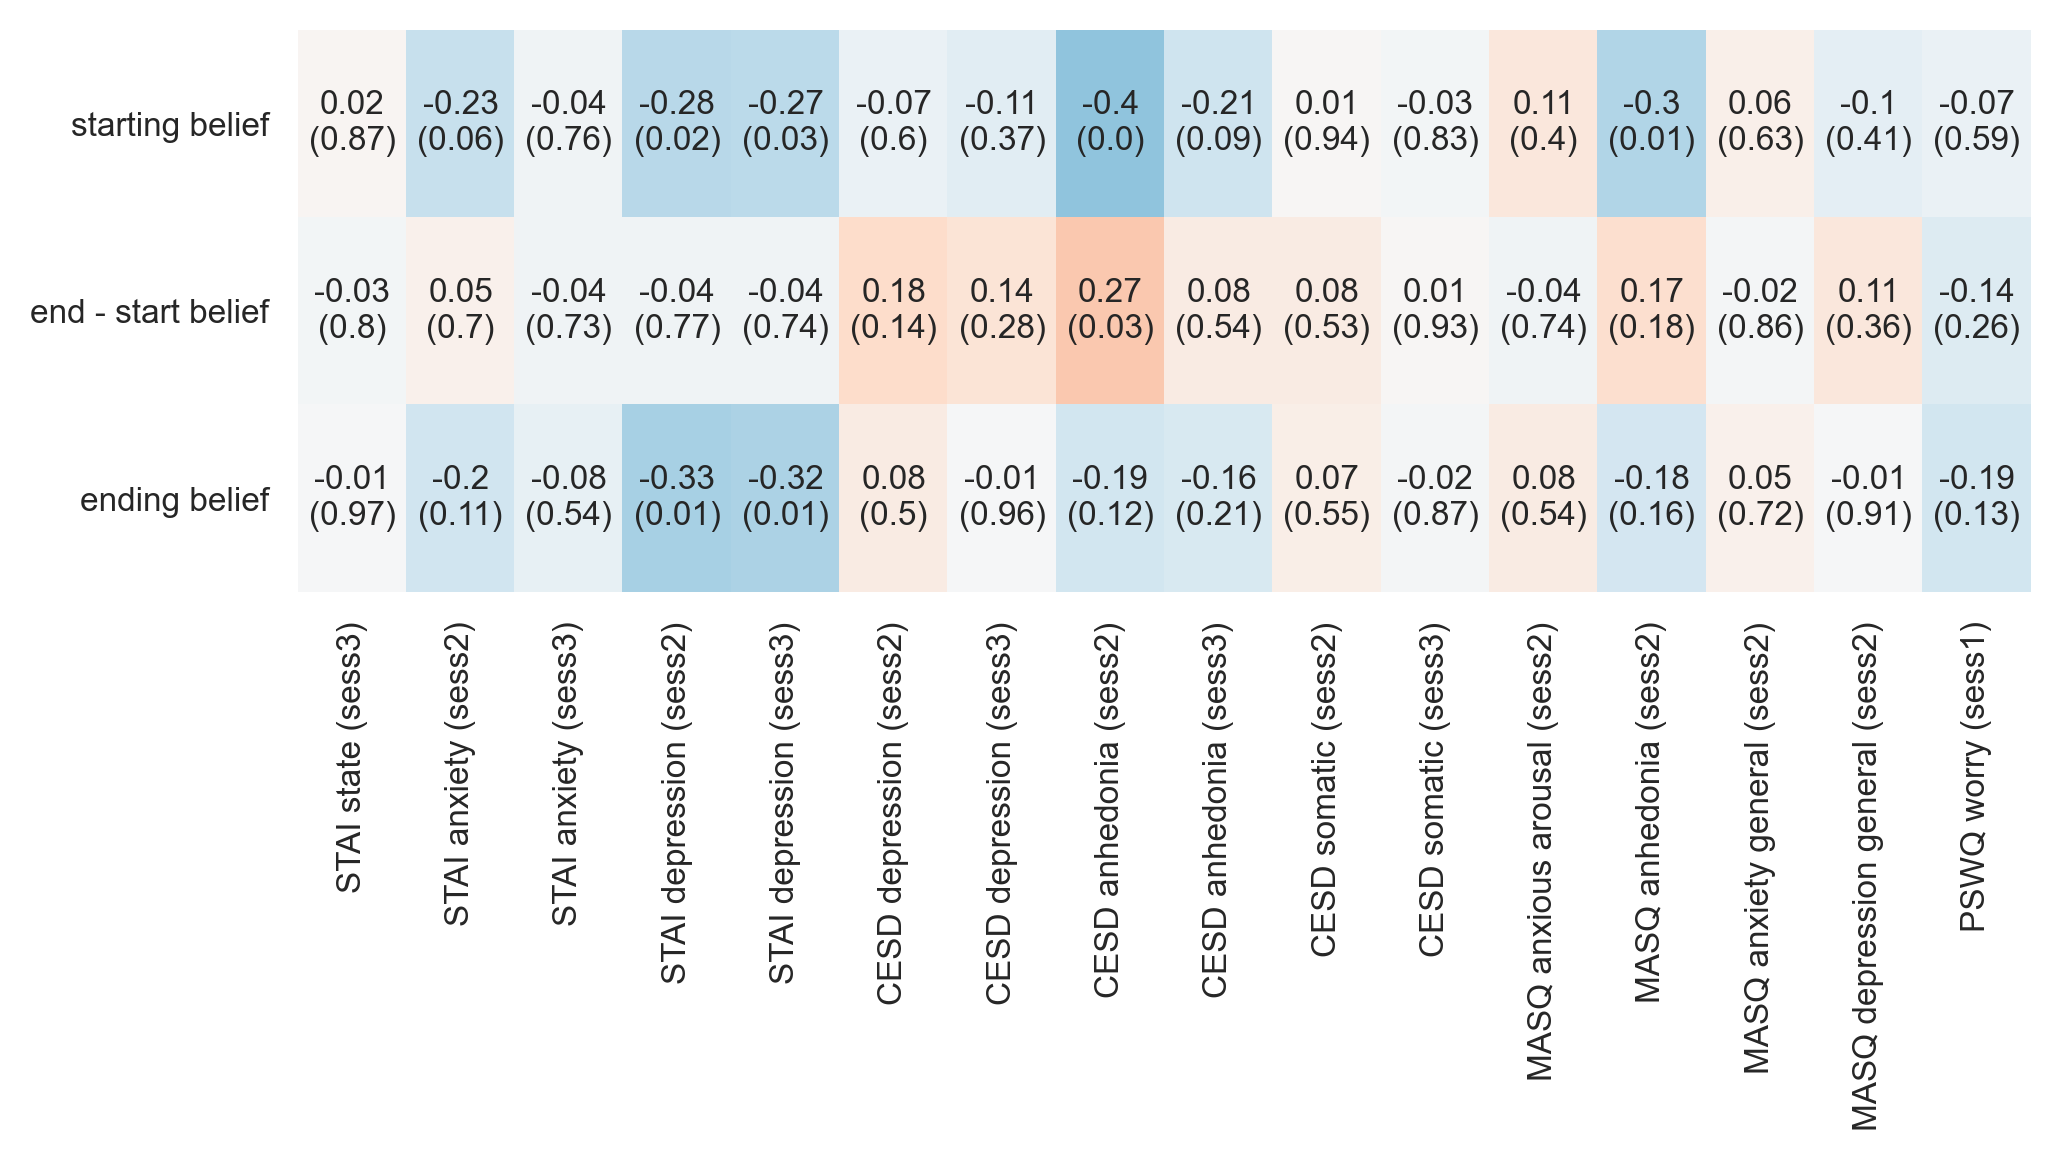

In [43]:
plt.figure(figsize=(7,4),dpi=300, facecolor='w')

# rename 
C = C.rename(name_replace_clinical,axis=0)#.rename(rename_dict,axis=1)
C_w_p = C_w_p.rename(name_replace_clinical,axis=0)
traits_renamed = [name_replace_clinical[trait] if trait in name_replace_clinical else trait for trait in traits]
ax = sns.heatmap(C.T[traits_renamed],annot=C_w_p.T[traits_renamed],vmax=1.0,vmin=-1,
                 cmap='RdBu_r', center=0,fmt='s',cbar=False,annot_kws = {'fontsize':8},cbar_kws ={'label':'Pearson r'})

plt.yticks(np.arange(3)+0.5,metrics,rotation=0,fontsize=ticklabelsize);
plt.xticks(fontsize=ticklabelsize)

# change colorbar size 
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(8)
cbar_axes.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
#plt.savefig('../figs_paper_submission/S7.png')
#plt.savefig('../figs_paper_submission/S7.tif')

### Figure S8 - model agnostic relationship between starting and ending belief

In [44]:
# get data from the best bayesian model on average (and more complex one)
modelname ='model_RW_update_w_report_samelr_relfbscaling'
model_fits_df_self,params_self = get_model_fit_data(modelname, df, selfother='self')
model_fits_df_other,params_other = get_model_fit_data(modelname, df, selfother='other')

/Users/chrisgagne/opt/miniconda3/envs/env_belief_updating/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chrisgagne/opt/miniconda3/envs/env_belief_updating/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


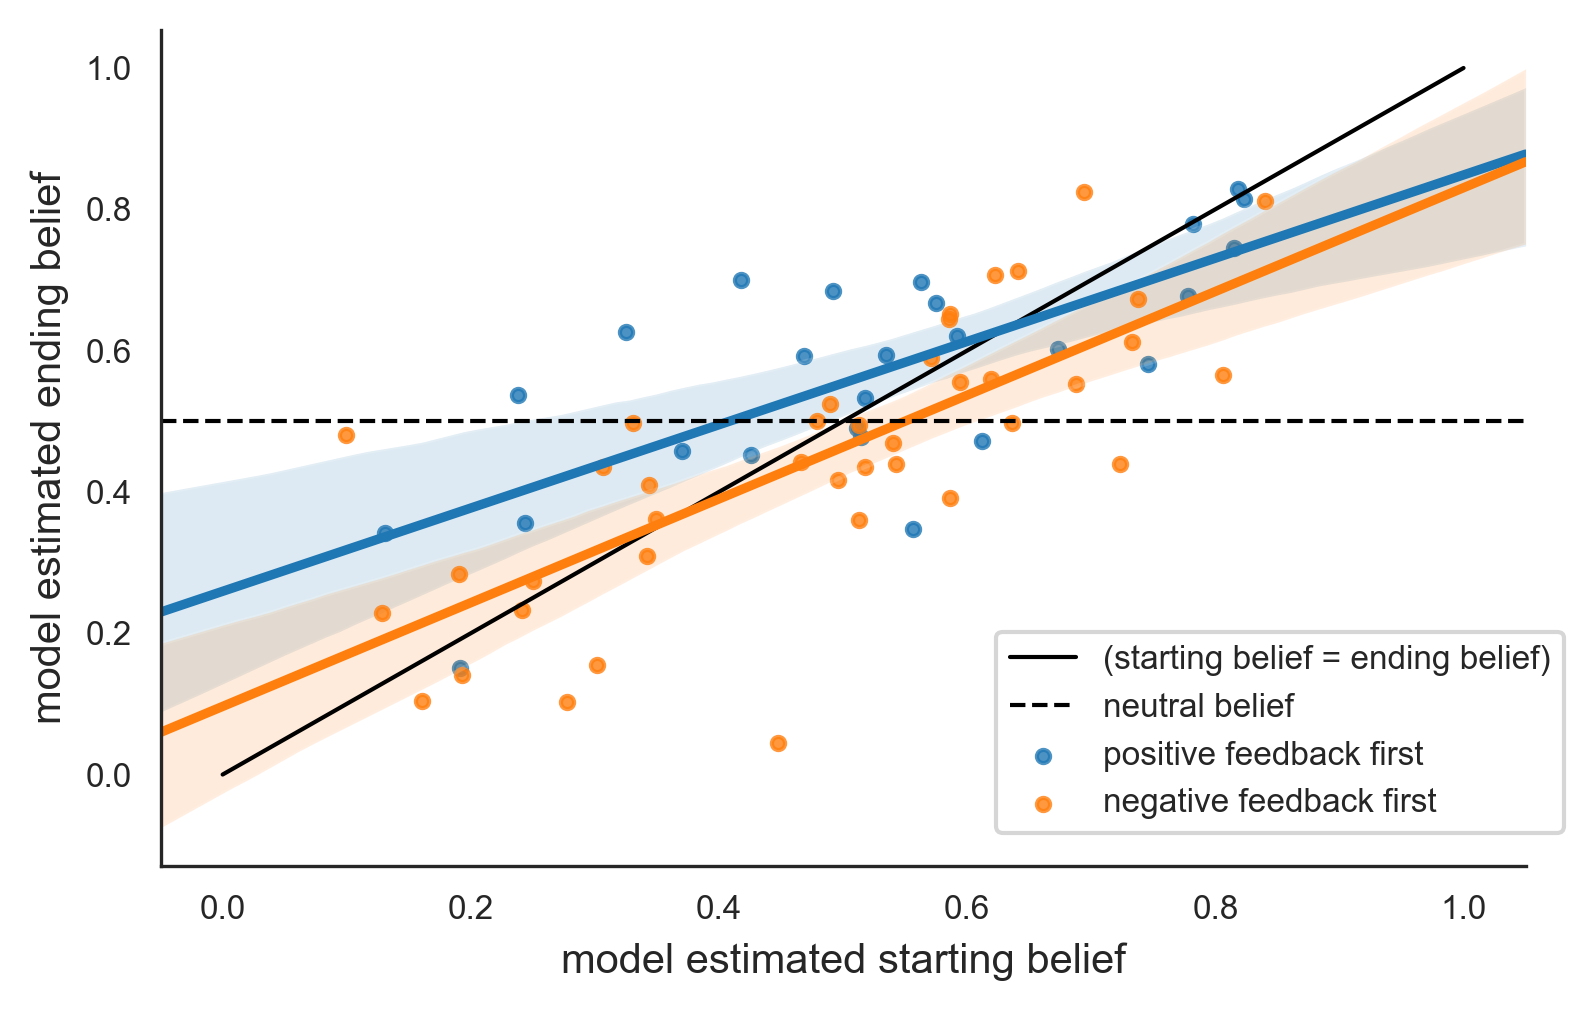

In [45]:
plt.figure(figsize=(6.5,3.5),dpi=300, facecolor='w')

x=model_fits_df_self['u_u0']
y=model_fits_df_self['u_last']
z=model_fits_df_self['self_feedback_cb']

sel1 = z==1
sel2 = z==0

s=10
plt.plot([0,1],[0,1],linestyle='-',linewidth=1,color='k',label='(starting belief = ending belief)')

sns.regplot(x[sel1],y[sel1],scatter_kws={'s':s},label='positive feedback first',truncate=False)
sns.regplot(x[sel2],y[sel2],scatter_kws={'s':s},label='negative feedback first',truncate=False)

plt.xlabel("model estimated starting belief",fontsize=labelsize)
plt.ylabel("model estimated ending belief",fontsize=labelsize)
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ticklabelsize)

sns.despine()
plt.axhline(y=0.5,linestyle='--',linewidth=1,color='k',label='neutral belief')

plt.legend(bbox_to_anchor=[0.6,0.3],fontsize=legendsize)
plt.tight_layout()
plt.gcf().subplots_adjust(left=0.15,right=0.85)
#plt.savefig('../figs_paper_submission/S8.png')
#plt.savefig('../figs_paper_submission/S8.tif')

### Figure S9 - best and worst fits

In [46]:
modelname ='model_RW_update_w_report_samelr_relfbscaling'
model_fits_df,params = get_model_fit_data(modelname, df)

In [48]:
stat = 'r2'
x = model_fits_df[stat]
x_sorting_idx = np.argsort(x)
x_sorted = x[x_sorting_idx]

In [49]:
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'font.family': 'normal'})
labelsize =10
ticklabelsize=8
legendsize=8

In [50]:
def plot_model(participant_estimates, model_estimates, model_estimates2=None, i=0, 
               title=None, new_figure=True, legend_location='upper left', 
               labelsize=12, ticklabelsize=12, legendsize=10, titlesize=10):
    
    if new_figure:
        plt.figure(figsize=(8,3), dpi=300)

    # plot data 
    plt.plot(participant_estimates[i], label="participant", marker='.',color='k')

    # plot model
    plt.errorbar(x=np.arange(len(participant_estimates[i])),
                 y=model_estimates.mean(axis=1)[i,:],
                 yerr=model_estimates.std(axis=1)[i,:],linewidth=1,
                 label='model (posterior mean+-std)',
                 marker='.');
    
    if model_estimates2 is not None:
        plt.errorbar(x=np.arange(len(participant_estimates[i])),
                     y=model_estimates2.mean(axis=1)[i,:],
                     yerr=model_estimates2.std(axis=1)[i,:],linewidth=1,
                     label='posterior mean (std) from model 2',
                     marker='.',alpha=0.8);


    plt.ylim([0,1])
    plt.legend(fontsize=legendsize, loc=legend_location, frameon=False)
    plt.xlabel('trials',fontsize=labelsize)
    plt.ylabel('belief',fontsize=labelsize)
    plt.xticks(fontsize=ticklabelsize)
    plt.yticks(fontsize=ticklabelsize)
    sns.despine()
    if title is not None:
        plt.title(title, fontsize=titlesize)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


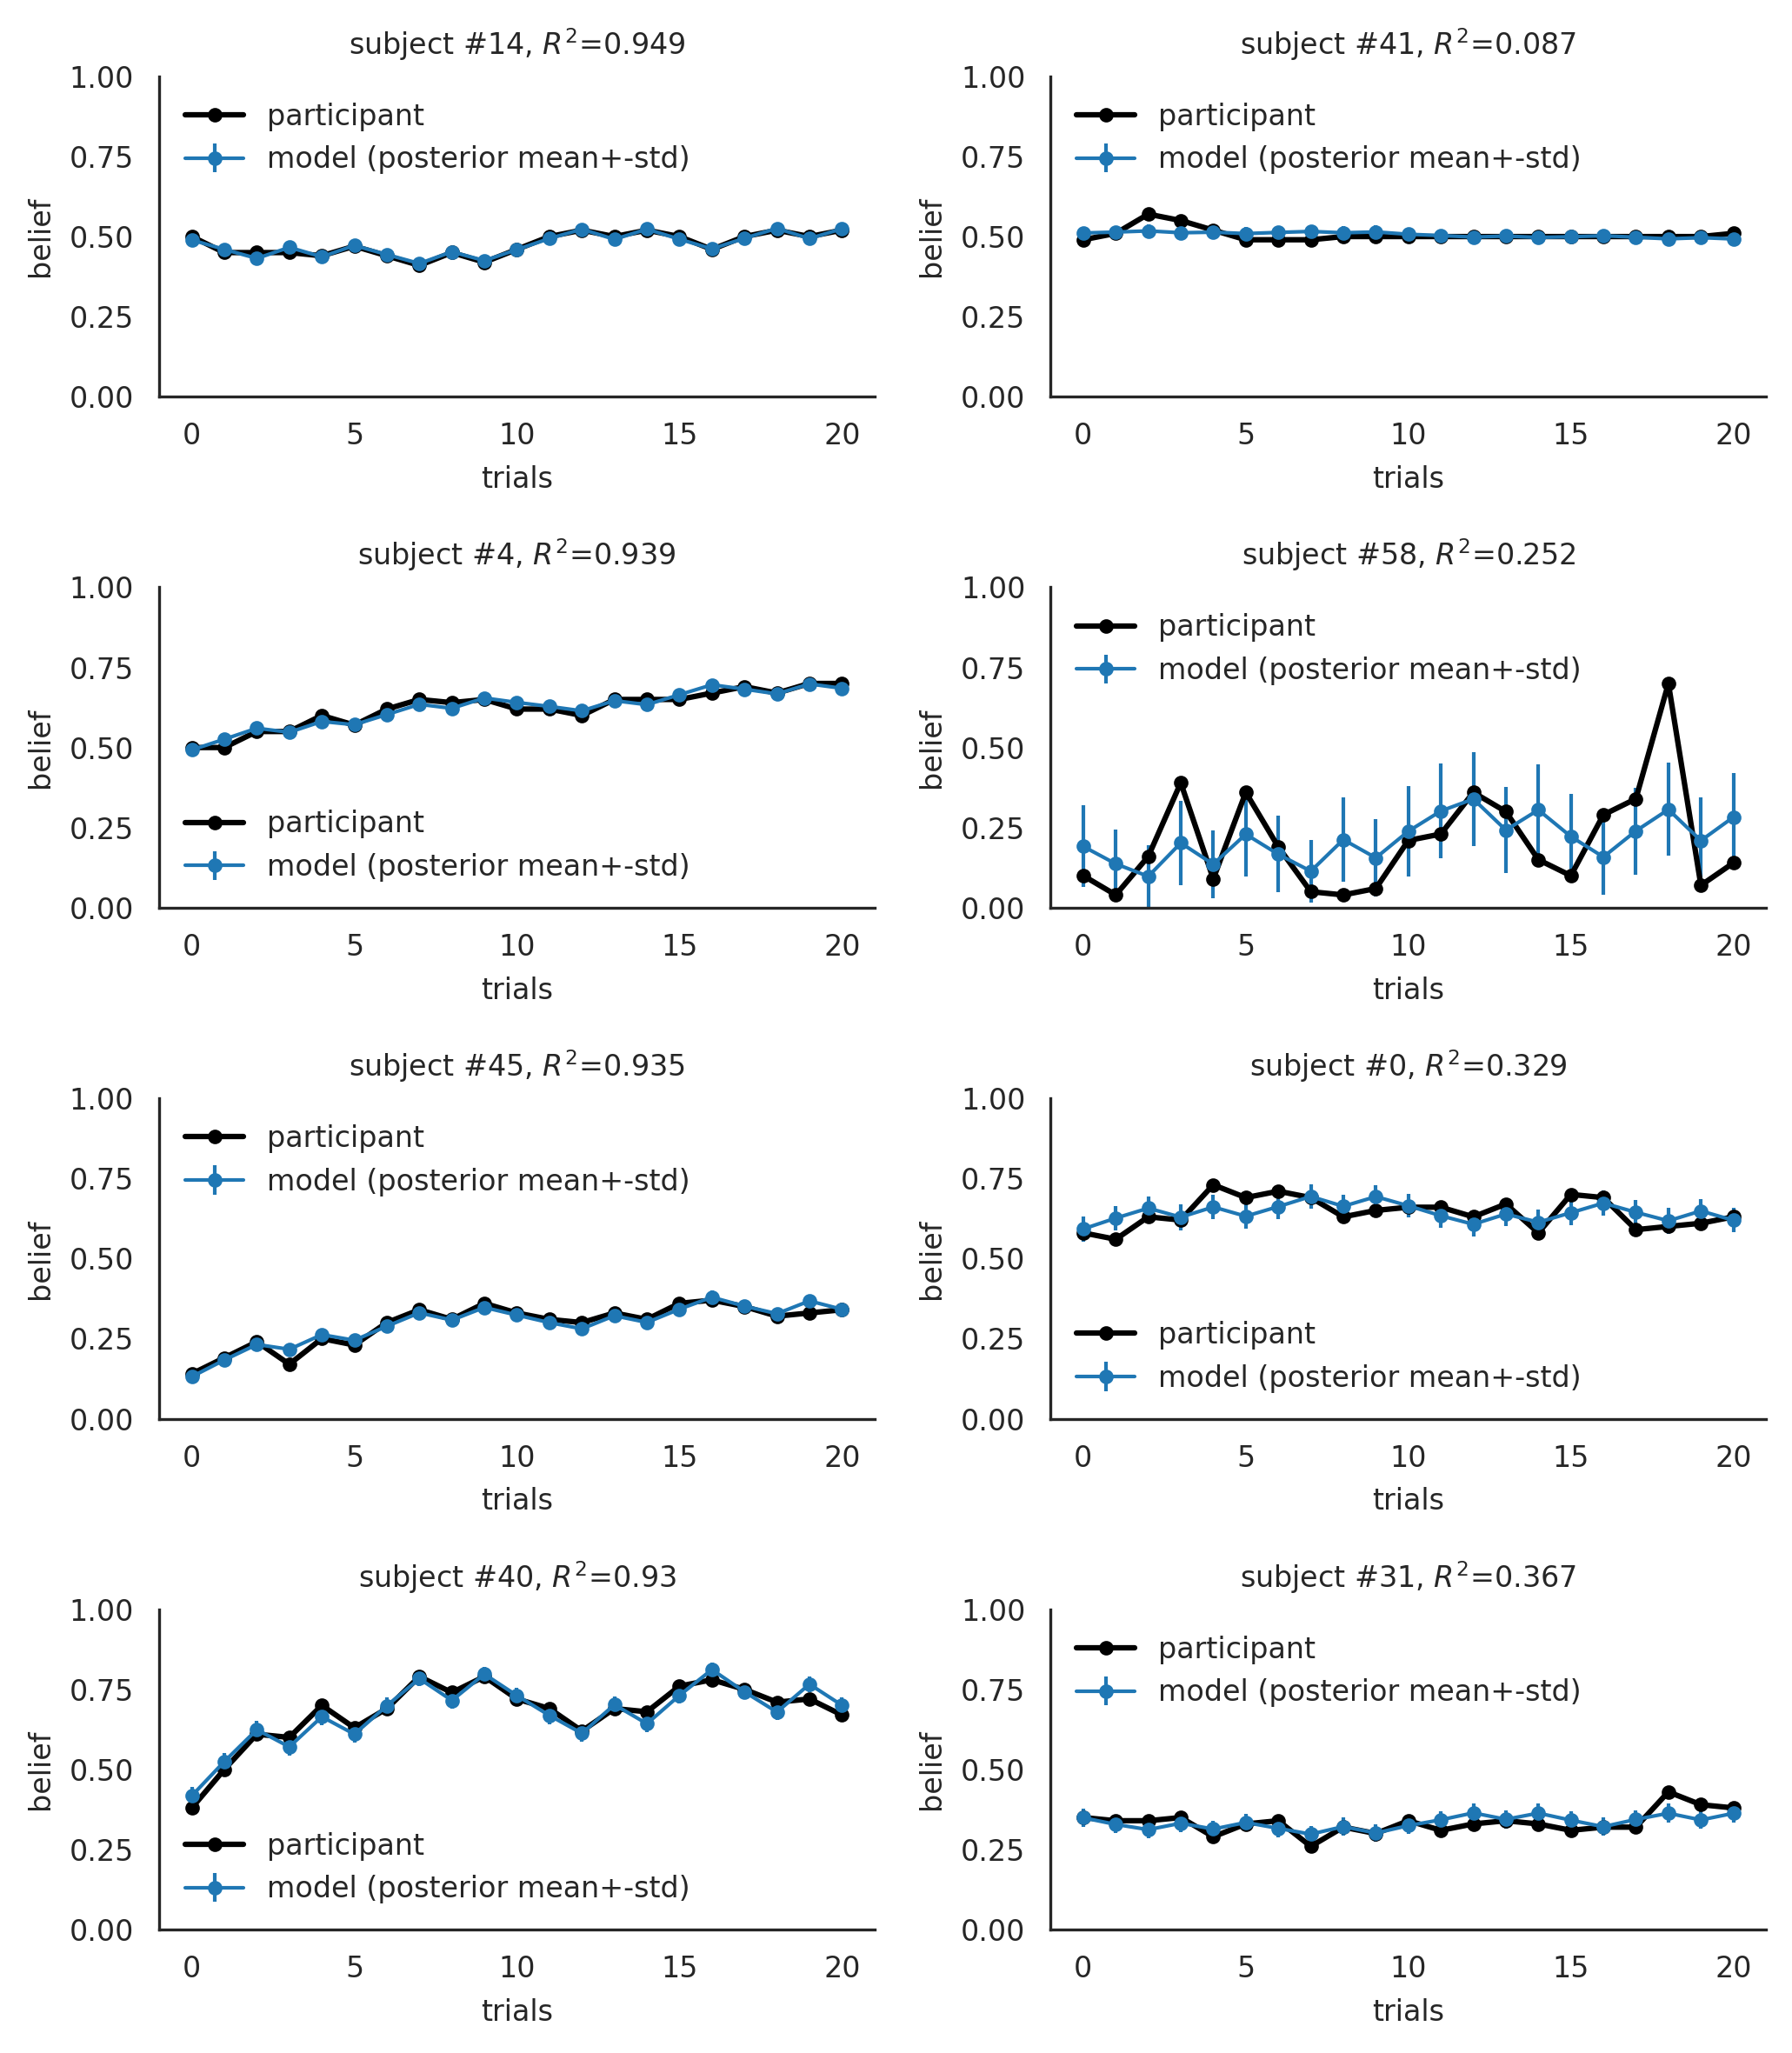

In [51]:

fig, axes = plt.subplots(4,2, figsize=(7,8), dpi=300, facecolor='w')
axes = axes.T.flatten()

# top 4 
counter=0
for i in x_sorted[-4:].index[::-1]:
    
    (model_estimates,_,_,_,
     feedbacks,participant_estimates,_,_,_)=generate_data_from_model(model_fits_df, df, S=1000)
    
    plt.sca(axes[counter])
    r2 = model_fits_df[stat][i]
    if i==40 or i==4:
        legend_loc = 'lower left'
    else:
        legend_loc = 'upper left'
    plot_model(participant_estimates, model_estimates, model_estimates2=None, i=i, 
               title=r'subject #'+str(i)+r', $R^2$='+str(r2), new_figure=False,
              labelsize=ticklabelsize, ticklabelsize=ticklabelsize, 
               legendsize=ticklabelsize, titlesize=ticklabelsize, legend_location=legend_loc)
    feedback=feedbacks[i]
    y = participant_estimates[i][feedback==1]
    x = np.where(feedback==1)[0]

    counter+=1
    
# bottom 4 
for i in x_sorted[0:4].index:
    
    (model_estimates,_,_,_,
     feedbacks,participant_estimates,_,_,_)=generate_data_from_model(model_fits_df, df, S=1000)
    
    plt.sca(axes[counter])
    r2 = model_fits_df[stat][i]
    if i==0:
        legend_loc = 'lower left'
    else:
        legend_loc = 'upper left'
    plot_model(participant_estimates, model_estimates, model_estimates2=None, i=i, 
               title=r'subject #'+str(i)+r', $R^2$='+str(r2), new_figure=False,
               labelsize=ticklabelsize, ticklabelsize=ticklabelsize, 
               legendsize=ticklabelsize, titlesize=ticklabelsize, legend_location=legend_loc)

    feedback=feedbacks[i]
    y = participant_estimates[i][feedback==1]
    x = np.where(feedback==1)[0]

    counter+=1
    
plt.tight_layout()
#plt.savefig('../figs_paper_submission/S9.png')
#plt.savefig('../figs_paper_submission/S9.tif')